## Mask R-CNN - Simulate the `DetectionTargetLayer` Process for COCO images

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

### Build Model

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

import mrcnn.utils        as utils
import mrcnn.visualize    as visualize
from datetime            import datetime   
from mrcnn.utils         import command_line_parser, Paths
from mrcnn.datagen       import data_generator, load_image_gt, data_gen_simulate
from mrcnn.prep_notebook import mrcnn_newshape_train
from mrcnn.newshapes     import prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
 
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs 2 "
input_parms +=" --steps_in_epoch 100 "
input_parms +=" --last_epoch     222" 
input_parms +=" --batch_size       1 " 
input_parms +=" --lr          0.0001 "
input_parms +=" --val_steps        8 " 
input_parms +=" --mrcnn_logs_dir  train_mrcnn_newshapes "
input_parms +=" --fcn_logs_dir    train_fcn_newshapes "
input_parms +=" --mrcnn_model     last "
input_parms +=" --fcn_model       init "
input_parms +=" --fcn_layers     fcn8 " 
input_parms +=" --fcn_arch       fcn8 " 
input_parms +=" --mrcnn_layers    mrcnn fpn rpn"
input_parms +=" --opt             adam "
input_parms +=" --scale_factor     1 " 
input_parms +=" --sysout        screen "
input_parms +=" --new_log_folder    "

args = parser.parse_args(input_parms.split())
# print(args)
utils.display_input_parms(args)
print(type(args.mrcnn_layers))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Arguments passed :
--------------------
batch_size                     1
coco_classes                   None
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['fcn8']
fcn_logs_dir                   train_fcn_newshapes
fcn_losses                     fcn_BCE_loss
fcn_model                      init
last_epoch                     222
lr                             0.0001
mrcnn_exclude_layers           None
mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
mrcnn_logs_dir                 train_mrcnn_newshapes
mrcnn_model                    last
new_log_folder                 True
opt                            ADAM
scale_factor                   1
steps_in_epoch                 100
sysout                         SCREEN
val_steps                      8


<class 'list'>


In [31]:
from mrcnn.prep_notebook import build_fcn_training_pipeline_newshapes
mrcnn_model, fcn_model = build_fcn_training_pipeline_newshapes(args = args, verbose = 1)
# mrcnn_model= mrcnn_newshape_train(args = args)


--> Execution started at: 12-20-2018 @ 19:29:34
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 

Arguments passed :
--------------------
batch_size                     1
coco_classes                   None
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['fcn8']
fcn_logs_dir                   train_fcn_newshapes
fcn_losses                     fcn_BCE_loss
fcn_model                      init
last_epoch                     222
lr                             0.0001
mrcnn_exclude_layers           None
mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
mrcnn_logs_dir                 train_mrcnn_newshapes
mrcnn_model                    last
new_log_folder                 True
opt                            ADAM
scale_factor                   1
steps_in_epoch                 100
sysout                         SCREEN
val_steps                      8



Arguments passed :
--------------------
batch_size                     1
coco_c

    FCN Block 53                   :  shape: (?, 8, 8, 512)        KB.shape:(None, 8, 8, 512)     Keras Tensor: True
    FCN Block 54 (Max pooling)     :  shape: (?, 4, 4, 512)        KB.shape:(None, 4, 4, 512)     Keras Tensor: True

   --- FCN32 ----------------------------
    FCN fully connected 1 (fc1)    :  shape: (?, 4, 4, 4096)       KB.shape:(None, 4, 4, 4096)    Keras Tensor: True
***** Call to Dropout Layer : Training is :  None
***** in_train_phase() : Use_learning_phase:  True
    FCN fully connected 2 (fc2)    :  shape: (?, 4, 4, 4096)       KB.shape:(None, 4, 4, 4096)    Keras Tensor: True
***** Call to Dropout Layer : Training is :  None
***** in_train_phase() : Use_learning_phase:  True
    FCN conv2d (fcn32_deconv2D)    :  shape: (?, 4, 4, 7)          KB.shape:(None, 4, 4, 7)       Keras Tensor: True

   --- FCN16 ----------------------------
    FCN scorePool4 (Conv2D(Pool4)) :  shape: (?, 8, 8, 7)          KB.shape:(None, 8, 8, 7)       Keras Tensor: True
    FCN 2x

    alt_scores_2                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_2(scattered)        :  shape: (1, 7, 32, 3)         KB.shape:(1, 7, 32, 3)         Keras Tensor: False
    alt_scores_2_norm(by_class)    :  shape: (1, 7, 32, 3)         KB.shape:(1, 7, 32, 3)         Keras Tensor: False
    alt_scores_2_norm(by_image)    :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    fcn_scores_dense               :  shape: (?, 23)               KB.shape:(None, 23)            Keras Tensor: False
    seq_ids                        :  shape: (?,)                  KB.shape:(None,)               Keras Tensor: False
    sscatter_ids                   :  shape: (?, 2)                KB.shape:(None, 2)             Keras Tensor: False
    fcn_scores_by_class            :  shape: (1, 7, 32, 23)        KB.shape:(1, 7, 32, 23)        Keras Tensor: False
    complete                       
  * fcn_scores shape

###  Load Model Weights

In [3]:
exclude=["mrcnn_class_logits" ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
# exclude = None
mrcnn_model.load_model_weights(init_with = 'coco', exclude = exclude)  

-----------------------------------------------
 Load Model with init parm: [ coco ]
 Exclude layers: 
    -  mrcnn_class_logits
    -  mrcnn_bbox_fc
-----------------------------------------------
 ---> coco : F:\PretrainedModels\mask_rcnn_coco.h5
>>> load_weights() from : F:\PretrainedModels\mask_rcnn_coco.h5
    Weights file loaded: F:\PretrainedModels\mask_rcnn_coco.h5 
MRCNN  MODEL Load weight file COMPLETE 


### Dataset

In [26]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# del dataset_train, dataset_val, train_generator, val_generator
# from mrcnn.prep_notebook import prep_newshape_dataset
dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 10000, generator=True)
dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  2500, generator=True)
class_names = dataset_train.class_names

Prepares complete
Prepares complete


### Display random samples from dataset

#### Display top masks for a random group of images

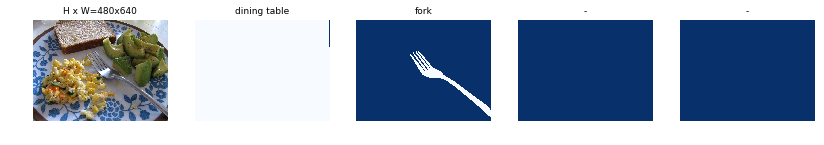

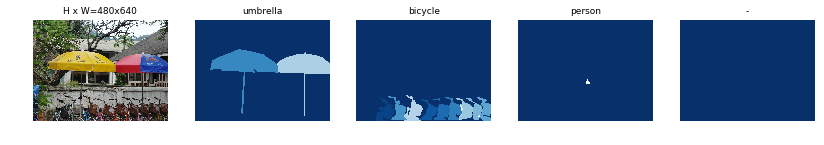

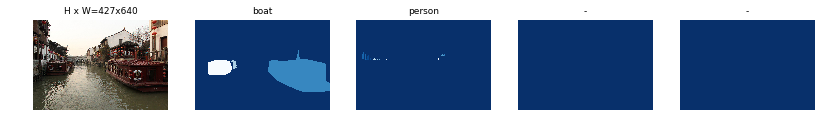

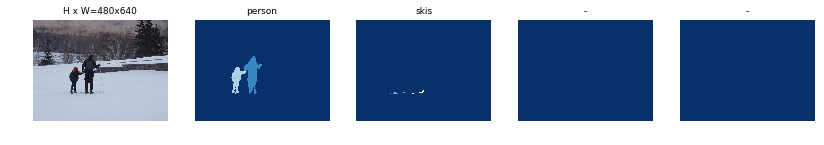

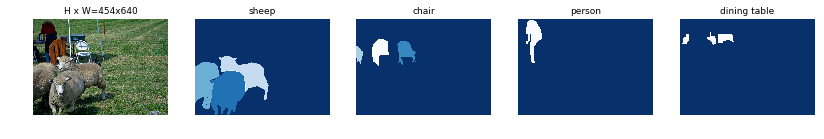

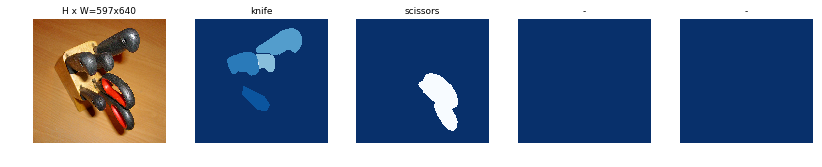

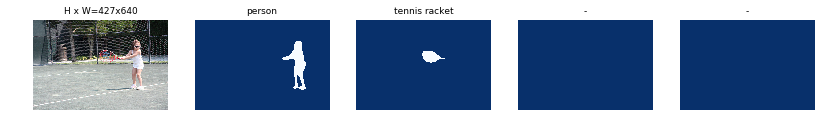

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display one image and it's instances

image_id  27711 http://cocodataset.org/#explore?id=324412
image                    shape: (346, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (346, 640, 7)         min:    0.00000  max:    1.00000
class_ids                shape: (7,)                  min:    1.00000  max:    9.00000
bbox                     shape: (7, 4)                min:  108.00000  max:  503.00000
7 7


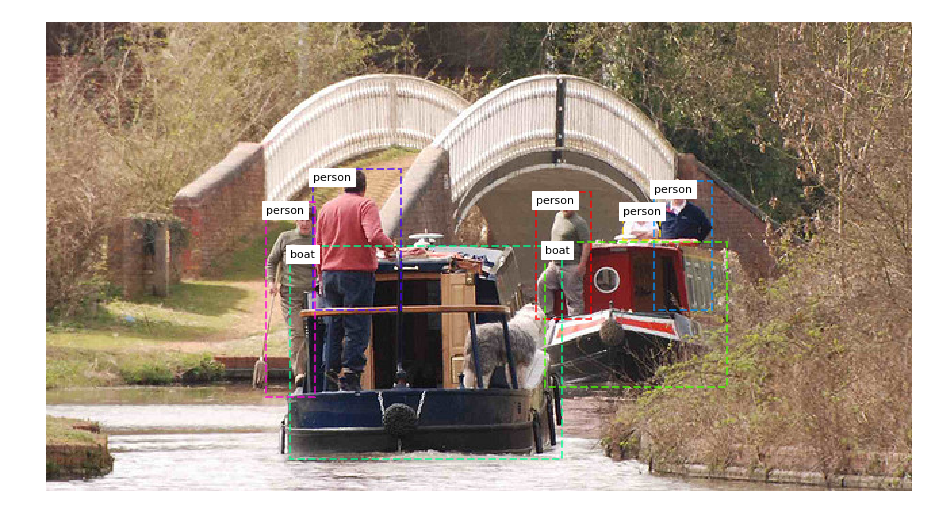

In [9]:
# Load random image and mask. ### 27711 persons and boats
image_id = np.random.choice(dataset_train.image_ids)
image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)
visualize.display_instances(image, bbox, class_ids, dataset_train.class_names)

### Get image from generator and display object instances

In [27]:
train_batch_x, train_batch_y = next(train_generator)

image id :  5013
 Image_id    :  5013  Reference:  [('sun', (171, 89, 217), (83, 13, 6, 6)), ('cloud', (166, 220, 26), (15, 22, 19, 4)), ('cloud', (9, 26, 116), (35, 24, 23, 5)), ('cloud', (233, 184, 165), (62, 26, 27, 5)), ('tree', (232, 240, 215), (67, 53, 10, 10)), ('tree', (213, 1, 102), (33, 54, 10, 10)), ('person', (125, 183, 232), (53, 86, 3, 15)), ('person', (120, 124, 9), (41, 87, 3, 15)), ('tree', (196, 202, 131), (26, 89, 19, 19)), ('person', (80, 3, 22), (75, 96, 3, 17)), ('person', (121, 25, 187), (90, 102, 3, 18)), ('car', (206, 220, 183), (69, 104, 28, 14))] Coco Id: 5013
 Image meta  :  [5013  128  128    3    0    0  128  128]
 Class ids   :  (12,)    [3 6 6 6 5 5 1 1 5 1 1 2]
 Class Names :  ['sun', 'cloud', 'cloud', 'cloud', 'tree', 'tree', 'person', 'person', 'tree', 'person', 'person', 'car']


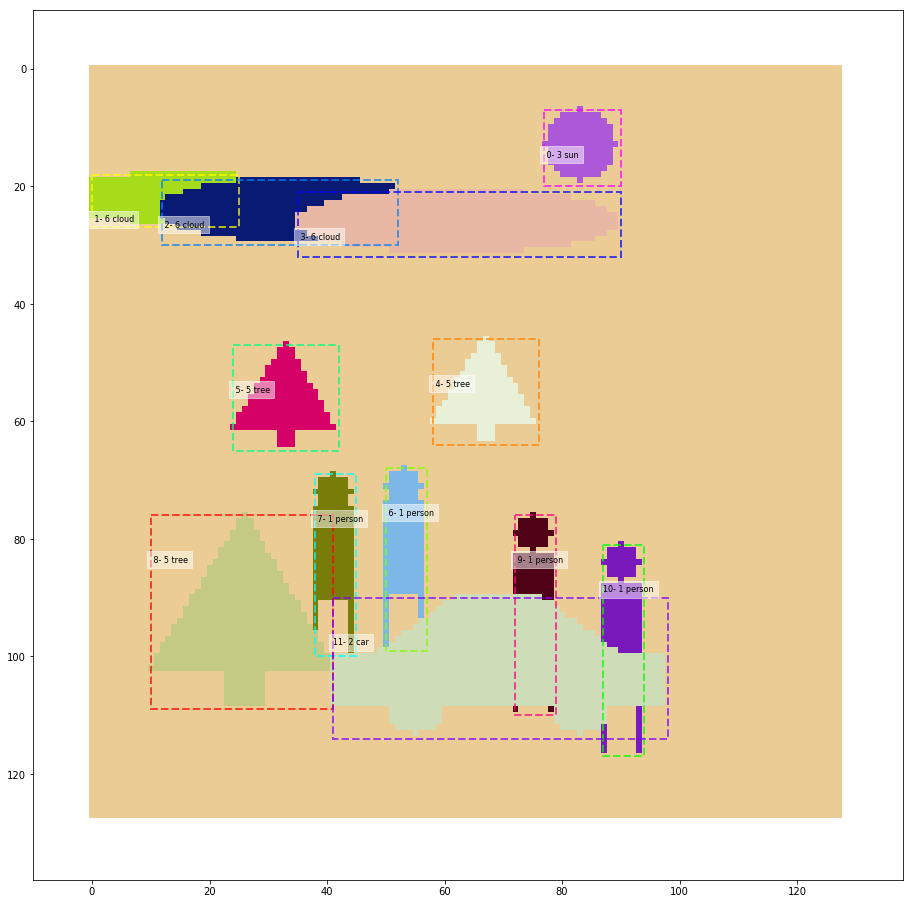

In [28]:
visualize.display_training_batch(dataset_train, train_batch_x)

In [7]:
# ### Display loaded shapes
# from mrcnn.datagen import data_gen_simulate
# # IMAGE_IDS = [36466]
# # IMAGE_IDS = [27711]
# # IMAGE_IDS = [29731]
# train_batch_x, train_batch_y = next(train_generator)
# # train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_IDS )
# # train_batch_x, train_batch_y = mrcnn.datagen_mod train_generator)

# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
# img_meta    = train_batch_x[imgmeta_idx]
# class_names = dataset_train.class_names

# for img_idx in range(mrcnn_config.BATCH_SIZE):
#     image_id = img_meta[img_idx,0]
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     bbox = utils.extract_bboxes(mask)
#     print('Image meta  : ', img_meta[img_idx,:10])
#     print('Classes     : ', class_ids)
#     print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
#     print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0])    
    
#     class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
#     print('Class Names : ', class_names)
    
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
#     # Display image and instances
#     visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8)) 

In [32]:
len(train_batch_x)

6

###  Print some model information 

In [6]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)


 Outputs:
 --------
 layer:  0    output name: rpn_class_logits/rpn_class_logits:0        Type: float32           Shape: (?, ?, 2)
 layer:  1    output name: rpn_class/rpn_class:0                      Type: float32           Shape: (?, ?, 2)
 layer:  2    output name: rpn_bbox/rpn_bbox:0                     

## Pass data through the model 

#### Push Data thru model using get_layer_output()

In [33]:
# model_output 
model_output = mrcnn_model.get_layer_outputs(train_batch_x,  verbose = True, training_flag = True)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 15)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Output shape: (1, 128, 128, 7)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 7, 32, 23)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 128, 128, 7)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 7, 32, 23)
Layer   4:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Output shape: (?, 32, 7)
Layer   5:  (mrcnn_bbox_

####  Load input data

In [155]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
print(' input_rpn_match         :', input_rpn_match.shape)
print(' input_rpn_bbox          :', input_rpn_bbox.shape)
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)

# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_gt_bboxes_norm = input_gt_bboxes / [h,w,h,w]
# print(' input_gt_bboxes_norm     :', input_gt_bboxes_norm.shape)

 Input image shape is    : (1, 1024, 1024, 3)
 Input image_meta        : (1, 89)
 input_image_meta        : [25164   480   640     3   128     0   896  1024     1     1]
 input_rpn_match         : (1, 261888, 1)
 input_rpn_bbox          : (1, 256, 4)
 input_gt_class_ids      : (1, 100)
 input_gt_bboxes         : (1, 100, 4)


#### Load output data

In [156]:
print(len(model_output))
# model_rpn_class_logits          = model_output[0]          # layer:  0   shape: (1, 261888, 2)
# model_rpn_class                 = model_output[1]          # layer:  1   shape: (1, 261888, 2)
# model_rpn_bbox                  = model_output[2]          # layer:  2   shape: (1, 261888, 4)
# model_rpn_roi_proposals         = model_output[3]          # layer:  3   shape: (1, 1000, 4)

# model_pred_heatmap              = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
# model_model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (1, 81, 200, 23)
# model_gt_heatmap                = model_output[2]          # layer:  2   shape: (1, 256, 256, 81)
# model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (1, 81, 200, 23)
model_mrcnn_class               = model_output[4]          # layer:  4   shape: (1, 200, 81)
model_mrcnn_bbox                = model_output[5]          # layer:  5   shape: (1, 200, 81, 4)
model_output_rois               = model_output[6]          # layer:  6   shape: (1, 200, 4)
model_target_class_ids          = model_output[7]          # layer:  7   shape: (1, 200)
model_roi_gt_boxes              = model_output[8]          # layer:  8   shape: (1, 200, 4)
model_mrcnn_class_logits        = model_output[9]          # layer:  9   shape: (1, 200, 81)
# model_active_class_ids          = model_output[10]          # layer: 10   shape: (1, 81)
model_rpn_roi_proposals         = model_output[11]          # layer: 11   shape: (1, 2000, 4)
for i in model_output:
    print( i.shape)

12
(1, 256, 256, 81)
(1, 81, 200, 23)
(1, 256, 256, 81)
(1, 81, 200, 23)
(1, 200, 81)
(1, 200, 81, 4)
(1, 200, 4)
(1, 200)
(1, 200, 4)
(1, 200, 81)
(1, 81)
(1, 2000, 4)


## Display output from Model

### Display raw outputs

####  Display `input_rpn_bboxes`

In [84]:
 
print(input_rpn_bbox.shape)
print(input_rpn_bbox[0,:10])


(1, 256, 4)
[[ 0.293   0.6641  0.5013 -0.6232]
 [ 0.293  -0.5859  0.5013 -0.6232]
 [-0.957   0.6641  0.5013 -0.6232]
 [-0.957  -0.5859  0.5013 -0.6232]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]


####  Display `rpn_class`

In [90]:
print(model_rpn_class.shape)
# print(model_rpn_class[0,:200] )
print(np.where(model_rpn_class[0,:,0] == 1.)[0].shape)
print(np.where(model_rpn_class[0,:,0] != 1.)[0].shape)

(1, 261888, 2)
(135059,)
(126829,)


####  Display `input_gt_class_ids`, `input_gt_bboxes_norm`, `input_gt_bboxes`

In [19]:

print(input_gt_class_ids.shape)
print(input_gt_class_ids[0])
print(input_gt_bboxes_norm.shape)
print(input_gt_bboxes_norm[0,:10])
print(input_gt_bboxes.shape)
print(input_gt_bboxes[0,:10])

(1, 100)
[48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
(1, 100, 4)
[[0.3691 0.3125 0.6455 0.5332]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]
(1, 100, 4)
[[378 320 661 546]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


####  Display `rpn_roi_proposals`

In [80]:
print(model_rpn_roi_proposals.shape)
# print(model_rpn_roi_proposals[0,:200] )
Y1 = model_rpn_roi_proposals[0,:,2] - model_rpn_roi_proposals[0,:,0]
X1 = model_rpn_roi_proposals[0,:,3] - model_rpn_roi_proposals[0,:,1]
print(Y1[:300])

(1, 2000, 4)
[0.0315 0.0589 0.0599 0.0334 0.031  0.0274 0.029  0.028  0.0359 0.0294 0.0318 0.0348 0.028  0.0274
 0.0604 0.0292 0.0324 0.0738 0.0234 0.0261 0.0513 0.0336 0.0315 0.0262 0.0366 0.0217 0.0403 0.0216
 0.0347 0.0279 0.0241 0.0282 0.049  0.0257 0.0266 0.0262 0.0348 0.0616 0.0321 0.0318 0.0276 0.0332
 0.0338 0.0268 0.0298 0.0312 0.0282 0.0348 0.0524 0.0325 0.0812 0.0204 0.0262 0.0365 0.0353 0.0299
 0.0285 0.0374 0.0247 0.0466 0.0341 0.0516 0.0268 0.0288 0.0432 0.0293 0.0391 0.0381 0.0276 0.0256
 0.0352 0.0229 0.0309 0.0251 0.0255 0.02   0.0407 0.0294 0.0279 0.0352 0.0429 0.0237 0.0257 0.0207
 0.0348 0.0375 0.0278 0.0278 0.0619 0.0241 0.0276 0.0283 0.0793 0.012  0.029  0.0524 0.0303 0.0374
 0.0327 0.0452 0.0384 0.0277 0.0387 0.0251 0.0286 0.0341 0.0353 0.0113 0.0241 0.0229 0.0241 0.037
 0.0827 0.0354 0.0347 0.0429 0.0763 0.0353 0.0194 0.0254 0.025  0.0302 0.0256 0.0312 0.0264 0.0538
 0.0358 0.0336 0.0359 0.0438 0.0351 0.0225 0.024  0.0213 0.0295 0.0152 0.0273 0.0194 0.0214 0.033

####  Display `target_bbox_delta`

In [66]:
print(target_bbox_deltas[0])

[[-0.733  -1.5274 -2.154   0.7884]
 [ 0.8325 -0.0459 -0.3248 -0.9467]
 [-2.078   0.9082 -0.4991  0.7059]
 [-1.4653  0.3945 -2.1779 -0.0342]
 [ 0.3144 -2.2589 -0.0003 -1.2789]
 [-1.0824 -1.0577  0.463  -0.639 ]
 [ 1.4148 -1.4174  1.7261  0.2058]
 [-1.1942  0.5464  0.2513 -0.2542]
 [ 0.3527 -2.4882  0.5647  0.0314]
 [ 2.741  -0.0058  1.8821  0.3344]
 [ 0.0367 -0.2212 -0.4588  0.0326]
 [-0.8904 -2.1475 -1.0763  0.9754]
 [ 0.8266  2.5855 -0.3017  0.196 ]
 [-0.4525 -0.5549 -0.6083 -0.5882]
 [ 0.5516 -1.5953 -0.1987  0.6263]
 [ 0.1791  0.2846 -0.4253 -0.8286]
 [-0.6037  0.2619 -1.1258  0.2515]
 [-0.057   1.4269 -0.5324 -1.6468]
 [-1.1011 -2.2867  0.79   -0.9047]
 [-0.1007  3.7157 -0.0249  1.2367]
 [ 0.1411 -1.633   1.0275 -0.4664]
 [ 1.2711 -0.1699 -0.3447 -0.2484]
 [ 0.6073 -0.4642  1.1728  1.799 ]
 [-0.5661  2.2486  0.0654  1.4653]
 [-0.1528  0.0667 -0.3133 -0.0545]
 [ 1.0604  2.5864  0.6854  2.404 ]
 [ 1.5721 -0.4305  0.9286 -0.4071]
 [-1.0425 -1.3241 -0.2952 -2.2901]
 [-0.5083 -0.0736  0

####  Compute refinement between `output_roi` and `roi_gt_bboxes` (individually and using numpy arrays)

In [69]:
pos_roi_count =  np.count_nonzero(target_class_ids[img_idx])
print('positiveroi count :', pos_roi_count)
for i in range(pos_roi_count+2):
    t1 = utils.box_refinement(output_rois[0,i], roi_gt_boxes[0,i])
    t1 = t1 / mrcnn_config.BBOX_STD_DEV
    
    print(' row {:2d}  {}  {}   '.format(i, output_rois[0,i],roi_gt_boxes[0,i]))
    print('                {}   {} '.format(t1, target_bbox_deltas[0,i]))

positiveroi count : 66
 row  0  [0.4067 0.226  0.4308 0.236 ]  [0.4092 0.2236 0.4248 0.2354]   
                [-0.733  -1.5274 -2.154   0.7884]   [-0.733  -1.5274 -2.154   0.7884] 
 row  1  [0.4043 0.7441 0.668  0.9482]  [0.4346 0.7607 0.6816 0.9297]   
                [ 0.8324 -0.0459 -0.3248 -0.9467]   [ 0.8325 -0.0459 -0.3248 -0.9467] 
 row  2  [0.4117 0.3132 0.4332 0.3302]  [0.4082 0.3135 0.4277 0.333 ]   
                [-2.078   0.9082 -0.4991  0.7059]   [-2.078   0.9082 -0.4991  0.7059] 
 row  3  [0.4073 0.3126 0.4375 0.3323]  [0.4082 0.3135 0.4277 0.333 ]   
                [-1.4653  0.3945 -2.1779 -0.0342]   [-1.4653  0.3945 -2.1779 -0.0342] 
 row  4  [0.4076 0.3163 0.4271 0.3416]  [0.4082 0.3135 0.4277 0.333 ]   
                [ 0.3144 -2.2589 -0.0003 -1.2789]   [ 0.3144 -2.2589 -0.0003 -1.2789] 
 row  5  [0.4155 0.8077 0.4368 0.831 ]  [0.4121 0.8066 0.4355 0.8271]   
                [-1.0824 -1.0577  0.463  -0.639 ]   [-1.0824 -1.0577  0.463  -0.639 ] 
 row  6  [0.4123 

../mrcnn/utils.py:676: RuntimeWarning: divide by zero encountered in log
  dh          = np.log(gt_height / height)
../mrcnn/utils.py:677: RuntimeWarning: divide by zero encountered in log
  dw          = np.log(gt_width / width)


####  display refinement

In [70]:
print(output_rois.shape, roi_gt_boxes.shape)    
t1 = utils.box_refinement_np(output_rois[0,:pos_roi_count],roi_gt_boxes[0,:pos_roi_count])
t1 = t1 / mrcnn_config.BBOX_STD_DEV
for i in range(pos_roi_count):
    print(' row {:2d}  {}  {}   '.format(i, t1[i],target_bbox_deltas[0,i]))    


(1, 200, 4) (1, 200, 4)
 row  0  [-0.733  -1.5274 -2.154   0.7884]  [-0.733  -1.5274 -2.154   0.7884]   
 row  1  [ 0.8325 -0.0459 -0.3248 -0.9467]  [ 0.8325 -0.0459 -0.3248 -0.9467]   
 row  2  [-2.078   0.9082 -0.4991  0.7059]  [-2.078   0.9082 -0.4991  0.7059]   
 row  3  [-1.4653  0.3945 -2.1779 -0.0342]  [-1.4653  0.3945 -2.1779 -0.0342]   
 row  4  [ 0.3144 -2.2589 -0.0003 -1.2789]  [ 0.3144 -2.2589 -0.0003 -1.2789]   
 row  5  [-1.0824 -1.0577  0.463  -0.639 ]  [-1.0824 -1.0577  0.463  -0.639 ]   
 row  6  [ 1.4148 -1.4174  1.7261  0.2058]  [ 1.4148 -1.4174  1.7261  0.2058]   
 row  7  [-1.1942  0.5464  0.2513 -0.2542]  [-1.1942  0.5464  0.2513 -0.2542]   
 row  8  [ 0.3527 -2.4882  0.5647  0.0314]  [ 0.3527 -2.4882  0.5647  0.0314]   
 row  9  [ 2.741  -0.0058  1.8821  0.3344]  [ 2.741  -0.0058  1.8821  0.3344]   
 row 10  [ 0.0367 -0.2212 -0.4588  0.0326]  [ 0.0367 -0.2212 -0.4588  0.0326]   
 row 11  [-0.8904 -2.1475 -1.0763  0.9754]  [-0.8904 -2.1475 -1.0763  0.9754]   
 row

####  display output_rois, 
- apply bbox_deltas to output_rois

In [73]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois', output_rois.shape)
print(output_rois [0,60:70]* [1024, 1024, 1024, 1024])

##---------------------------------------------------------------------------
## applying bbox deltas to output_rois results in the corresponding gt_bbox
## for POSITIVE proposals in the output_roi. For negative samples, it returns 
## in the negative_bbox coordinates itself. 
##---------------------------------------------------------------------------
print('------------------------------------')
print(' Applying bbox deltas to output_rois')
print('------------------------------------')
print(' BBOX STD DEV: ', mrcnn_config.BBOX_STD_DEV)
t1 = target_bbox_deltas * mrcnn_config.BBOX_STD_DEV

print('\n target_bbox_deltas (normalized): ', target_bbox_deltas[0].shape)
print(target_bbox_deltas[0,:70])
print('\n target_bbox_deltas (normalized) * STD_DEV  : ', t1.shape)
print(t1[0,:70])
# print('\n target_bbox_deltas (unnormalized): ', target_bbox_deltas[0].shape)
# print(target_bbox_deltas[0,60:70]* [1024, 1024, 1024, 1024])
# print('\n target_bbox_deltas (unnormalized) * STD_DEV  : ', t1.shape)
# print(t1[0,60:70]* [1024, 1024, 1024, 1024])
 
t2 = utils.apply_box_deltas(output_rois[0], t1[0] )
t2 *= [1024, 1024, 1024, 1024]
print('\n output_rois after apply bbox_deltas : ', t2.shape)


print('    row       output_rois               delta-adjusted output_rois     roi_gt_bboxes')
for i in range(70):
    print(' row {:2d}  {}   {}  {}'.format(i, output_rois[0,i]* [1024, 1024, 1024, 1024],t2[i], roi_gt_boxes[0,i]* [1024, 1024, 1024, 1024]))

# print(t2.astype(int)[:70])
# print('\n roi_gt_bboxes')
# print(roi_gt_boxes[0,:70]* [1024, 1024, 1024, 1024])

 output_rois (1, 200, 4)
[[417.8371 232.0388 436.7685 243.943 ]
 [677.4376 700.2401 727.1846 901.4907]
 [418.2982   1.2197 442.4895  13.3238]
 [662.0091 512.6924 739.7035 644.9308]
 [675.2047 173.0125 753.858  306.7514]
 [428.5226 905.1876 443.6053 918.3893]
 [414.0381 237.7954 430.057  249.2353]
 [557.218  786.1843 564.2641 812.7214]
 [416.3351 908.3521 425.1101 919.3723]
 [406.415   96.4947 411.5413 106.0513]]
------------------------------------
 Applying bbox deltas to output_rois
------------------------------------
 BBOX STD DEV:  [0.1 0.1 0.2 0.2]

 target_bbox_deltas (normalized):  (200, 4)
[[-0.733  -1.5274 -2.154   0.7884]
 [ 0.8325 -0.0459 -0.3248 -0.9467]
 [-2.078   0.9082 -0.4991  0.7059]
 [-1.4653  0.3945 -2.1779 -0.0342]
 [ 0.3144 -2.2589 -0.0003 -1.2789]
 [-1.0824 -1.0577  0.463  -0.639 ]
 [ 1.4148 -1.4174  1.7261  0.2058]
 [-1.1942  0.5464  0.2513 -0.2542]
 [ 0.3527 -2.4882  0.5647  0.0314]
 [ 2.741  -0.0058  1.8821  0.3344]
 [ 0.0367 -0.2212 -0.4588  0.0326]
 [-0.8904

#### Display `roi_gt_boxes` and `input_gt_boxes`

In [74]:
print(' roi_gt_boxes  : ', roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:20])
print(roi_gt_boxes[0,:20]* [1024, 1024, 1024, 1024])

print(' input_gt_bboxes: ', input_gt_bboxes.shape)
print(input_gt_bboxes[img,:20])
 

 roi_gt_boxes  :  (1, 200, 4)
[[ 419.  229.  435.  241.]
 [ 445.  779.  698.  952.]
 [ 418.  321.  438.  341.]
 [ 418.  321.  438.  341.]
 [ 418.  321.  438.  341.]
 [ 422.  826.  446.  847.]
 [ 421. 1000.  446. 1016.]
 [ 667.  520.  723.  632.]
 [ 421. 1000.  446. 1016.]
 [ 421. 1000.  446. 1016.]
 [ 667.  520.  723.  632.]
 [ 418.  321.  438.  341.]
 [ 419.   13.  438.   25.]
 [ 414.    0.  440.   11.]
 [ 419.  229.  435.  241.]
 [ 422.  826.  446.  847.]
 [ 419.  229.  435.  241.]
 [ 421. 1000.  446. 1016.]
 [ 421. 1000.  446. 1016.]
 [ 422.  826.  446.  847.]]
 input_gt_bboxes:  (1, 100, 4)
[[ 667  520  723  632]
 [ 690  715  735  877]
 [ 691  184  749  310]
 [ 445  779  698  952]
 [ 421  515  699  651]
 [ 435  137  717  386]
 [ 418  321  438  341]
 [ 419  229  435  241]
 [ 419   13  438   25]
 [ 422  826  446  847]
 [ 421 1000  446 1016]
 [ 430  906  445  923]
 [ 432  965  446 1024]
 [ 414    0  440   11]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0 

#### Display `mrcnn_class`

In [75]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

print(' mrcnn_class', mrcnn_class.shape)
# print( mrcnn_class[0,-1])
max_mrcnn_class    = np.max(mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(mrcnn_class, axis = 2)

print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

print()
print('\n mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class)

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

 mrcnn_class (1, 200, 81)


 mrcnn_class Max Values   :  (200,)
[0.842  0.9997 0.9467 0.9387 0.9724 0.8843 0.6633 0.9946 0.6355 0.7398 0.9944 0.9874 0.9374 0.6656 0.9056 0.9814 0.9445 0.7673 0.6746 0.9738 0.7803 0.8518 0.8295 0.9902 0.9999 0.7114 0.9827 0.6539 0.9935
 0.8391 0.8214 0.9161 0.5337 0.6811 0.8944 0.7737 0.9946 0.9055 0.9127 0.8718 0.8131 0.7631 0.542  0.982  0.5008 0.9932 0.9951 0.4431 0.993  0.9998 0.9996 0.9807 0.9999 0.7946 0.7964 0.9123 0.8177 0.9139
 0.9832 0.5614 0.8024 0.9875 0.7204 0.9915 0.9931 0.8187 0.9997 0.9893 0.9999 0.9999 0.9597 0.9466 0.9991 0.9999 0.9947 0.9998 0.9959 0.9959 1.     0.9947 0.6746 1.     0.9996 0.9999 1.     0.9964 0.9907
 0.9982 0.9995 1.     0.9469 0.9941 1.     0.9983 0.998  0.9424 0.9246 0.9988 0.9956 0.9999 0.9945 0.9996 0.7615 0.9716 1.     0.9991 0.9997 1.     0.9999 0.5529 0.9998 0.9955 0.999  0.9986 1.     0.9995
 0.9993 0.9955 0.9997 0.9999 0.5107 0.9994 0.9302 0.9995 0.9996 0.9981 0.9972 0.9997 0.9999 0.9998 0.9992 1.     0.958  

#### Display `mrcnn_bbox`

In [76]:
print('mrcnn+_bbox.shape', mrcnn_bbox.shape)
print()
print(mrcnn_bbox[0,0,:,:]* mrcnn_config.BBOX_STD_DEV)

mrcnn+_bbox.shape (1, 200, 81, 4)

[[ 0.0191  0.0017  0.0238 -0.0161]
 [-0.0502 -0.1254 -0.2947 -0.006 ]
 [ 0.0068 -0.1063 -0.2907  0.0607]
 [-0.037  -0.1399 -0.3502  0.104 ]
 [-0.0244 -0.1241 -0.3774  0.0113]
 [-0.0321 -0.1125 -0.2703 -0.0213]
 [-0.0483 -0.1208 -0.304   0.0552]
 [-0.105  -0.1146 -0.2806  0.0871]
 [-0.083  -0.118  -0.2968  0.097 ]
 [-0.0264 -0.1341 -0.3074  0.0392]
 [-0.049  -0.1226 -0.3461 -0.0338]
 [-0.0144 -0.1079 -0.316  -0.1028]
 [-0.0654 -0.1299 -0.4491 -0.0715]
 [-0.0497 -0.1159 -0.2856 -0.0992]
 [-0.0003 -0.1137 -0.2533  0.1243]
 [-0.0461 -0.1308 -0.2759 -0.0466]
 [-0.0418 -0.1251 -0.3391 -0.0759]
 [-0.0361 -0.1228 -0.3126 -0.0714]
 [-0.0217 -0.1451 -0.3517 -0.0019]
 [-0.0354 -0.1392 -0.3216 -0.0085]
 [-0.0421 -0.1417 -0.3608 -0.0379]
 [-0.03   -0.1348 -0.3389  0.016 ]
 [-0.0254 -0.1158 -0.2871 -0.0763]
 [-0.0219 -0.1132 -0.2921  0.018 ]
 [-0.0568 -0.1265 -0.2739  0.0014]
 [-0.0555 -0.1364 -0.4384 -0.0547]
 [-0.0509 -0.139  -0.3367 -0.0427]
 [-0.0257 -0.1097 -0

#### Display  `mrcnn_bbox` and apply `mrcnn_delta` to `output_rois`

In [79]:
print(' mrcnn_bbox', mrcnn_bbox.shape)

for i, delta in enumerate(mrcnn_bbox[0,:]):
    # each delta is a 81 x 4 array
    class_id     = argmax_mrcnn_class[0,i]
    print('bbox/cls: {}/{}  '.format(i,class_id))
    print('mrcnn_bbox_deltas for bbox ',i)
#     print(delta)

    mrcnn_delta  = delta[class_id]
    mrcnn_delta_2 = mrcnn_delta * mrcnn_config.BBOX_STD_DEV
    print('delta for predicted class:', class_id)
    print('          output_roi:  {} '.format( output_rois[0,i]))
    print('         mrcnn_delta:  {}  mrcnn_delta * BBOX_STD_DEV:{} '.format(mrcnn_delta ,mrcnn_delta_2))
    
    tgt_delta   = target_bbox_deltas[0,i]
    tgt_delta_2 = tgt_delta * mrcnn_config.BBOX_STD_DEV
    print('           tgt_delta:  {}    tgt_delta * BBOX_STD_DEV:{} '.format(tgt_delta ,tgt_delta_2))

    t2 = utils.apply_box_delta(output_rois[0,i], mrcnn_delta_2 ) * [1024, 1024,1024, 1024]
    t3 = utils.apply_box_delta(output_rois[0,i], tgt_delta_2  )  * [1024.0, 1024.0,1024.0, 1024.0]
    print(' adjusted output_roi using rcnn_bbox_delta: ', t2)
    print(' adjusted output_roi using  tgt_bbox_delta: ', t3)
    print('                              roi_gt_boxes: ', roi_gt_boxes[0,i] * [1024, 1024,1024, 1024])
print(input_gt_bboxes[0:20])    

 mrcnn_bbox (1, 200, 81, 4)
bbox/cls: 0/1  
mrcnn_bbox_deltas for bbox  0
delta for predicted class: 1
          output_roi:  [0.4067 0.226  0.4308 0.236 ] 
         mrcnn_delta:  [-0.5023 -1.2535 -1.4734 -0.0298]  mrcnn_delta * BBOX_STD_DEV:[-0.0502 -0.1254 -0.2947 -0.006 ] 
           tgt_delta:  [-0.733  -1.5274 -2.154   0.7884]    tgt_delta * BBOX_STD_DEV:[-0.0733 -0.1527 -0.4308  0.1577] 
 adjusted output_roi using rcnn_bbox_delta:  [418.4014 230.1864 436.7344 240.375 ]
 adjusted output_roi using  tgt_bbox_delta:  [419. 229. 435. 241.]
                              roi_gt_boxes:  [419. 229. 435. 241.]
bbox/cls: 1/1  
mrcnn_bbox_deltas for bbox  1
delta for predicted class: 1
          output_roi:  [0.4043 0.7441 0.668  0.9482] 
         mrcnn_delta:  [ 0.8698  0.1052 -0.2075 -1.3613]  mrcnn_delta * BBOX_STD_DEV:[ 0.087   0.0105 -0.0415 -0.2723] 
           tgt_delta:  [ 0.8325 -0.0459 -0.3248 -0.9467]    tgt_delta * BBOX_STD_DEV:[ 0.0832 -0.0046 -0.065  -0.1893] 
 adjusted output_

                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 76/0  
mrcnn_bbox_deltas for bbox  76
delta for predicted class: 0
          output_roi:  [0.7244 0.1896 0.7516 0.2755] 
         mrcnn_delta:  [0.1643 0.0113 0.044  0.1836]  mrcnn_delta * BBOX_STD_DEV:[0.0164 0.0011 0.0088 0.0367] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [742.1045 192.6525 770.1876 283.8188]
 adjusted output_roi using  tgt_bbox_delta:  [741.7701 194.1971 769.6072 282.0762]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 77/0  
mrcnn_bbox_deltas for bbox  77
delta for predicted class: 0
          output_roi:  [0.4086 0.2168 0.4212 0.2267] 
         mrcnn_delta:  [-0.1332 -0.2199  0.2246 -0.1241]  mrcnn_delta * BBOX_STD_DEV:[-0.0133 -0.022   0.0449 -0.0248] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [417.9142 221.869

         mrcnn_delta:  [ 0.154  -0.049   0.2109  0.0246]  mrcnn_delta * BBOX_STD_DEV:[ 0.0154 -0.0049  0.0422  0.0049] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [480.8786 624.0076 496.5507 644.1315]
 adjusted output_roi using  tgt_bbox_delta:  [480.9709 624.155  495.9957 644.1801]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 130/0  
mrcnn_bbox_deltas for bbox  130
delta for predicted class: 0
          output_roi:  [0.4873 0.8343 0.5075 0.8617] 
         mrcnn_delta:  [ 0.4518 -0.0555  0.1437 -0.0433]  mrcnn_delta * BBOX_STD_DEV:[ 0.0452 -0.0055  0.0287 -0.0087] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [499.647  854.2955 520.8955 882.0941]
 adjusted output_roi using  tgt_bbox_delta:  [499.015  854.3303 519.6616 882.3705]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 131/0  

delta for predicted class: 0
          output_roi:  [0.4901 0.3645 0.4994 0.3758] 
         mrcnn_delta:  [0.3602 0.0174 0.0667 0.1131]  mrcnn_delta * BBOX_STD_DEV:[0.036  0.0017 0.0133 0.0226] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [502.1858 373.1418 511.8285 385.0189]
 adjusted output_roi using  tgt_bbox_delta:  [501.9069 373.2544 511.4218 384.8658]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 195/0  
mrcnn_bbox_deltas for bbox  195
delta for predicted class: 0
          output_roi:  [0.4143 0.9701 0.4307 0.986 ] 
         mrcnn_delta:  [-0.1914 -0.2166  0.2186 -0.0243]  mrcnn_delta * BBOX_STD_DEV:[-0.0191 -0.0217  0.0437 -0.0049] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [ 423.5428  993.0251  441.0854 1009.2656]
 adjusted output_roi using  tgt_bbox_delta:  [ 424.2394  993.3389  441.0315 1009

In [ ]:
### Display loaded shapes
# from mrcnn.datagen_mod import data_gen_simulate
## 36466, 27711 
# train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, 36466)
# train_batch_x, train_batch_y = mrcnn.datagen_mod train_generator)

# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]
class_names = dataset_train.class_names

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    num_gt_bboxes = bbox.shape[0]
    print(' Image id        : ', image_id)
    print(' Image meta      : ', img_meta[img_idx,:12])
    print(' Window          : ', img_meta[img_idx, 4:8])
    print(' Class_ids shape : ', class_ids.shape)
    print(' Image shape    : ', image.shape)
    print(' bbox from extract bboxes() : ',bbox.shape)
 
    print(' GT_BBOXES in H:{} x W:{} context  -- total {} boxes'.format(image.shape[0],image.shape[1], num_gt_bboxes))
    print(bbox)
    print()
    print('image_gt_bboxes in H:{} x W:{} context'.format(input_image.shape[1], input_image.shape[2]))
    print(input_gt_bboxes[0,:num_gt_bboxes])
    print()
#     visualize.display_instances(image, bbox, class_ids, dataset_train.class_names)
#     print('--------------------------------------------------------')
#     print(' Utils.resize_image():')
#     molded_image, window, scale, padding = utils.resize_image(
#                 image,
#                 min_dim = mrcnn_config.IMAGE_MIN_DIM,
#                 max_dim = mrcnn_config.IMAGE_MAX_DIM,
#                 padding = mrcnn_config.IMAGE_PADDING)
#     print(' Image shape      : ', image.shape)
#     print(' Molded image size: ', molded_image.shape)
#     print(' Window           : ', window)
#     print(' scale            : ', scale)
#     print(' padding          : ', padding)
#     print('--------------------------------------------------------')

#     visualize.display_image(image, title = 'original image')
#     visualize.display_image(molded_image, title = 'molded image')

#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
#     visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

    

### `input_gt_bboxes` : Transform to orininal image coordinates and display

In [ ]:
    
    t1 = utils.boxes_to_image_domain(input_gt_bboxes[img_idx], img_meta[img_idx])
    print(' input_gt_bboxes transformed to image domain:')
    print(t1 [:20])        
    visualize.display_instances(image, t1[:num_gt_bboxes], input_gt_class_ids[0,:num_gt_bboxes], dataset_train.class_names, title='Using image_gt_bboxes')    
    

###  `output_rois`  :  Transform to original image coordinates and display (No delta corrections)

 boxes_to_image_domain() 
    Original image shape : [480 640   3]   Image window info: [ 128    0  896 1024] 
    Adjustment shift     : [0.625 0.625 0.625 0.625]   Adjustment Scale : [128   0] 
    Adjusted boxes shape : (200, 4) 
 display_instances() : Image shape:  (480, 640, 3)


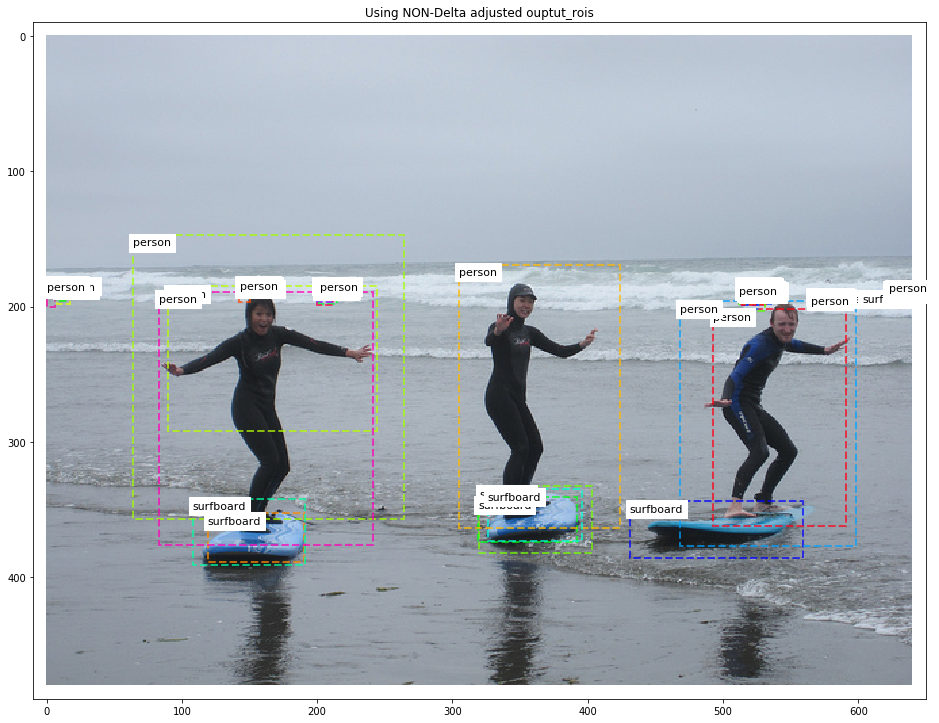

In [230]:
    
##  t4:non delta-adjusted output rois 
    t4 = utils.boxes_to_image_domain(output_rois[img_idx] * [1024,1024,1024,1024], img_meta[img_idx])
#     print(t2 [:20])        
    visualize.display_instances(image, t4[:pos_roi_count], target_class_ids[0,:pos_roi_count], dataset_train.class_names, 
                                title='Using NON-Delta adjusted ouptut_rois')     

###  `output_rois`  : Apply delta corrections and tranform to original image coordinates and display

positiveroi count : 66

bbox deltas shape:  (1, 200, 4)
[[ 0.1828  0.1382  0.2941  0.1599]
 [-0.0473 -0.1334  0.0894  0.3342]
 [ 0.0025  0.0169  0.2038 -0.0505]
 [-0.1082 -0.1058  0.0926 -0.1278]
 [-0.0754 -0.0213 -0.3274 -0.1661]
 [ 0.1305 -0.1457  0.1476 -0.3436]
 [ 0.1722 -0.1496 -0.119  -0.0652]
 [-0.1228 -0.0123 -0.0863  0.208 ]
 [ 0.1477  0.0719  0.0355 -0.1426]
 [ 0.3808 -0.0239  0.5     0.0094]
 [-0.1194  0.0546  0.0503 -0.0508]
 [ 0.1304 -0.0057 -0.1776 -0.248 ]
 [-0.0402  0.1725 -0.1182  0.2464]
 [-0.0063  0.0118 -0.3916 -0.2345]
 [-0.1642 -0.0893 -0.285  -0.2279]
 [ 0.0527  0.0884  0.1125  0.1009]
 [-0.0173 -0.0619  0.2352 -0.2526]
 [-0.0508 -0.0074  0.0123  0.1004]
 [ 0.0841  0.2363 -0.0175 -0.0743]
 [ 0.0695  0.0532 -0.3046 -0.0596]
 [ 0.1022 -0.1885 -0.1316 -0.1034]
 [-0.2128  0.0322 -0.1817  0.0624]
 [-0.2078  0.0908 -0.0998  0.1412]
 [-0.0927  0.0472 -0.1947 -0.0533]
 [-0.016  -0.2512 -0.1682  0.008 ]
 [ 0.017  -0.0028 -0.1158 -0.336 ]
 [ 0.1935  0.0316  0.2063  0.3595]

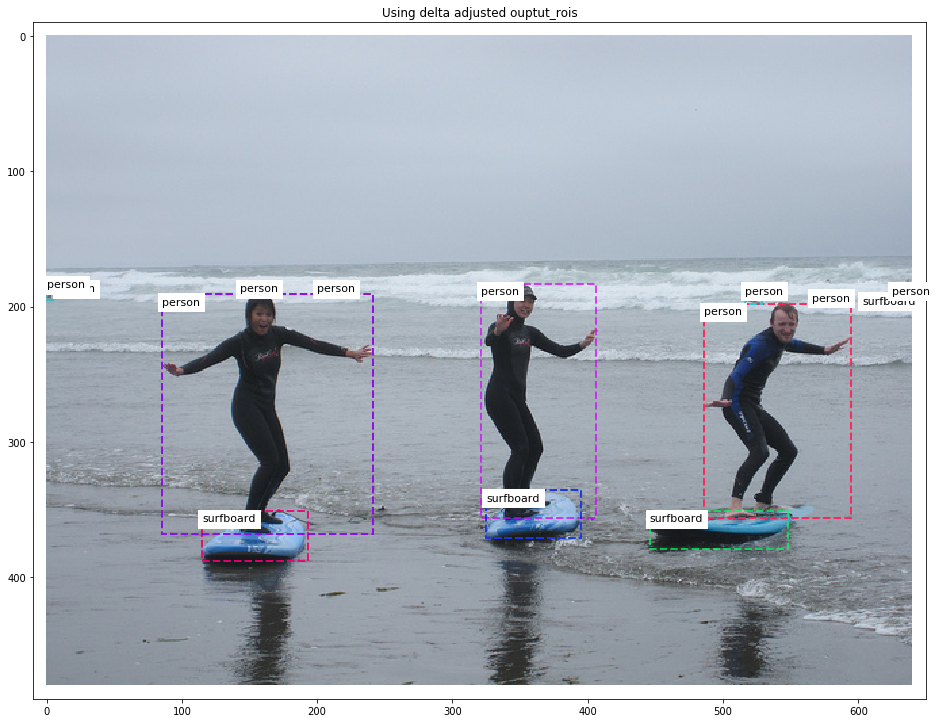

In [231]:
    pos_roi_count =  np.count_nonzero(target_class_ids[img_idx])
    print('positiveroi count :', pos_roi_count)
    bbox_deltas = target_bbox_deltas * mrcnn_config.BBOX_STD_DEV
    print()
    print('bbox deltas shape: ', bbox_deltas.shape)
    print(bbox_deltas[0,:70])

    print()
    print('output_rois in H:{} x W:{} context'.format(input_image.shape[1], input_image.shape[2]))
    print('shape :',output_rois.shape)
    print(output_rois[0,:70])

    t2 = utils.apply_box_deltas(output_rois[0], bbox_deltas[0]) 
    print()
    print(' output_rois adjusted by bbox_deltas :', t2.shape)
    print(t2[:70])

    t3 = utils.boxes_to_image_domain(t2 * [1024,1024,1024,1024] , img_meta[img_idx])
    print()
    print(' output_rois adjusted by bbox_deltas :', t3.shape)
    print(t3[:70])
    visualize.display_instances(image, t3[:pos_roi_count], target_class_ids[0,:pos_roi_count], dataset_train.class_names, 
                                title='Using delta adjusted ouptut_rois')      
 

#### Display  `target_class_ids()`

In [220]:
print(' target_class_ids : ', target_class_ids.shape)
print(target_class_ids[0,:90])
print(' target_')
print(np.count_nonzero(target_class_ids[0]))

 target_class_ids :  (1, 200)
[ 1  1  1  1 38  1  1  1  1  1 38  1 38 38  1  1  1 38 38 38  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 38 38 38  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 target_
66


In [17]:
# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

# print(' mrcnn_bbox')
# print( mrcnn_bbox.shape)
# print( mrcnn_bbox)

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

input_gt_class_ids
[38 38 38  1  1  1  1  1  1  1  1  1 38  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 output_rois
(1, 200, 4)
[[ 425.783   995.6045  446.5938 1020.1833]
 [ 425.1773 1002.7977  446.5236 1021.9712]
 [ 422.3943  828.2659  443.1353  850.8389]
 [ 420.8128  998.5729  447.1609 1014.7355]
 [ 679.6332  691.177   746.2022  895.992 ]
 [ 417.3315  317.9491  439.2289  334.9991]
 [ 419.7754  323.0784  441.5788  339.3224]
 [ 420.0803  824.3909  443.4798  841.3549]
 [ 415.5219  324.3896  432.7296  340.4197]
 [ 428.8941  908.5911  446.877   927.5968]
 [ 414.4317  318.8742  437.286   345.3727]
 [ 420.4667  823.4021  446.5974  848.1871]
 [ 398.6457  488.3748  710.7618  678.6857]
 [ 425.343   144.0605  596.3816  390.7286]
 [ 420.7793  999.2968  439.4089 1012.9329]
 [ 425.4

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [17]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print('input_gt_class_ids')
print(input_gt_class_ids[0])

# print(' rpn_bbox')
# print(rpn_bbox.shape)
# print(rpn_bbox[0,:100,:])

# print(' rpn_roi_proposals')
# print(rpn_roi_proposals.shape)
# print(rpn_roi_proposals[0,:100,:])

print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

# print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])
 

# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:,:])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

input_gt_class_ids
[38 38 38  1  1  1  1  1  1  1  1  1 38  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 output_rois
(1, 200, 4)
[[ 425.783   995.6045  446.5938 1020.1833]
 [ 425.1773 1002.7977  446.5236 1021.9712]
 [ 422.3943  828.2659  443.1353  850.8389]
 [ 420.8128  998.5729  447.1609 1014.7355]
 [ 679.6332  691.177   746.2022  895.992 ]
 [ 417.3315  317.9491  439.2289  334.9991]
 [ 419.7754  323.0784  441.5788  339.3224]
 [ 420.0803  824.3909  443.4798  841.3549]
 [ 415.5219  324.3896  432.7296  340.4197]
 [ 428.8941  908.5911  446.877   927.5968]
 [ 414.4317  318.8742  437.286   345.3727]
 [ 420.4667  823.4021  446.5974  848.1871]
 [ 398.6457  488.3748  710.7618  678.6857]
 [ 425.343   144.0605  596.3816  390.7286]
 [ 420.7793  999.2968  439.4089 1012.9329]
 [ 425.4

In [12]:
# print(rpn_roi_proposals[0])
# print(np.argmax(mrcnn_class[0],axis=1))
print(mrcnn_class[0,:20])
print(np.max(mrcnn_class[0,:],axis = 1))
argmax = np.argmax(mrcnn_class[0,:],axis = 1)
print(' arg_max. mrcnn_class')
print(argmax)
print()
for i in argmax:
    print(class_names[i])
# print(output_rois[0])
# print(pred_tensor[0])

[[0.018  0.9814 0.     ... 0.     0.     0.    ]
 [0.2677 0.7293 0.0001 ... 0.     0.     0.    ]
 [0.2258 0.7611 0.0001 ... 0.     0.     0.    ]
 ...
 [0.0055 0.     0.     ... 0.     0.     0.    ]
 [0.0003 0.9997 0.     ... 0.     0.     0.    ]
 [0.1434 0.842  0.     ... 0.     0.     0.    ]]
[0.9814 0.7293 0.7611 0.854  0.9724 0.9998 0.562  0.6519 0.5253 0.8295 0.9127 0.9944 0.9738 0.5337
 0.7673 0.6811 0.7946 0.9915 0.9997 0.842  0.9705 0.7398 0.9387 0.9951 0.9423 0.9996 0.9467 0.6633
 0.9539 0.5793 0.8187 0.7158 0.9417 0.8296 0.8518 0.9123 0.982  0.9374 0.9999 0.4431 0.7964 0.7204
 0.6355 0.9139 0.8944 0.9807 0.993  0.9946 0.8718 0.6869 0.9004 0.9759 0.8104 0.9056 0.3935 0.915
 0.9998 0.3691 0.9499 0.9161 0.6746 0.8826 0.949  0.8131 0.9584 0.7803 0.9996 0.9988 1.     0.9993
 0.9976 0.9982 0.9655 1.     0.9862 0.998  0.9995 0.9986 0.9678 0.9998 0.9965 0.9685 0.9994 1.
 0.9968 0.9965 0.5131 0.995  0.9995 0.9998 1.     0.999  1.     0.9992 0.9972 0.9986 0.9451 0.9779
 0.9989 0.99

In [23]:
# print(input_gt_boxes.shape, input_image.shape)

# print((rpn_proposal_rois[0,:5,:]*[128,128,128,128]))
# print(input_gt_class_ids)
print(input_normlzd_gt_bboxes)
print(input_gt_bboxes_norm.shape)
print(rpn_roi_proposals.shape)

Tensor("Identity:0", shape=(1, 100, 4), dtype=float64)
(1, 100, 4)
(1, 2000, 4)


## `detections_target_graph()`

###  Setup tensors to be passed to `detections_target_graph()`

This is passed to the DetectionTargetLayer

     output_rois, target_class_ids, target_bbox_deltas,  roi_gt_boxes = \
                DetectionTargetLayer_mod(config, name="proposal_targets") ([rpn_proposal_rois, input_gt_class_ids, input_normlzd_gt_boxes])                

In [157]:
import mrcnn.utils  as utils
# from mrcnn.detect_tgt_layer_mod import overlaps_graph_mod

image_id = 0
proposals    = KB.identity(model_rpn_roi_proposals)[image_id]
gt_class_ids = KB.identity(input_gt_class_ids)[image_id]
gt_boxes     = KB.cast(KB.identity(input_gt_bboxes_norm), dtype='float32')[image_id]


config       = mrcnn_model.config
# gt_masks     = KB.identity(input_gt_masks)
print(proposals.dtype, gt_class_ids.dtype, gt_boxes.dtype)
print(proposals.shape)
#     print(proposals.eval())
print(gt_class_ids.shape)
# print(gt_class_ids.eval())
print(gt_boxes.shape)
# print(gt_boxes.eval())
# proposals    = rpn_roi_proposals[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

<dtype: 'float32'> <dtype: 'int32'> <dtype: 'float32'>
(2000, 4)
(100,)
(100, 4)


### def `dev_detection_targets_graph`

Copied from detection_target_layer_mod on 8/30/2018

In [159]:
# def detection_targets_graph_mod(proposals, gt_class_ids, gt_boxes,  config):
 
# with sess.as_default():

'''
Generates detection targets for one image. Subsamples proposals and
generates target class IDs, bounding box deltas, and masks for each.

Inputs:
-------
proposals:              [N, 2000, (y1, x1, y2, x2)] in normalized coordinates. 
                        Proposals passed from the proposal layer.
                        Might be zero padded if there are not enough proposals.

gt_class_ids:           [MAX_GT_INSTANCES] 
                        ground truth object class ids 

gt_boxes:               [MAX_GT_INSTANCES, (y1, x1, y2, x2)] 
                        ground truth bbox normalized coordinates 

gt_masks:               [height, width, MAX_GT_INSTANCES] of boolean type.
                        ground truth mask information

Returns:            Target ROIs and corresponding class IDs, bounding box shifts, and masks.
--------
output_rois:            [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
                        Contains BOTH POSITIVE and NEGATIVE examples

target_class_ids:       [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
                        only contains POSTITIVE exmaples

target_bbox_deltas:     [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
                        Class-specific bbox refinments between the  POSITIVE examples
                        (in target_gt_bboxes) and their ground truth counter parts (in output_rois)

target_gt_bboxes        [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)]                   
(roi_gt_bboxes)         Ground Truth bbox coordinates - Only for POSITIVE examples

target_gt_masks:        [TRAIN_ROIS_PER_IMAGE, height, width). Masks cropped to bbox
                        boundaries and resized to neural network output size.
                        only for POSITIVE examples.

Note: Returned arrays might be zero padded if not enough target ROIs.

''' 
# Assertions
asserts = [
    tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals], name="roi_assertion"),
]

with tf.control_dependencies(asserts):
    proposals = tf.identity(proposals)
# print('>>> detection_targets_graph ')
# print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
# print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
# print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
# print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

# Remove zero padding   
# non_zeros returns indicies to valid bboxes, which we use to index gt_class_ids, and gt_masks
proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
# gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

In [23]:
#------------------------------------------------------------------------------------------
# Handle COCO crowds
# A crowd box in COCO is a bounding box around several instances. Exclude
# them from training. A crowd box is given a negative class ID.
#------------------------------------------------------------------------------------------
# tf.where : returns the coordinates of true elements of  the specified conditon.
#            The coordinates are returned in a 2-D tensor where the first dimension (rows) 
#            represents the number of true elements, and the second dimension (columns) 
#            represents the coordinates of the true elements. 
#            Keep in mind, the shape of the output tensor can vary depending on how many 
#            true values there are in input. Indices are output in row-major order.
#
# tf.gather: Gather slices from params axis (default = 0) according to indices.
#            indices must be an integer tensor of any dimension (usually 0-D or 1-D). 
#            Produces an output tensor with shape:
#                   params.shape[:axis] + indices.shape + params.shape[axis + 1:] 
#
# tf.squeeze: Removes dimensions of size 1 from the shape of a tensor.
#            Given a tensor input, this operation returns a tensor of the same type with 
#            all dimensions of size 1 removed. If you don't want to remove all size 1 
#            dimensions, you can remove specific size 1 dimensions by specifying axis.
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------
##  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications
#------------------------------------------------------------------------------------------
crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]    
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)    
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)

gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes    , non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

#------------------------------------------------------------------------------------------
# Compute overlaps with crowd boxes [anchors, crowds]
#------------------------------------------------------------------------------------------
crowd_overlaps  = overlaps_graph_mod(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)


#------------------------------------------------------------------------------------------
# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
#------------------------------------------------------------------------------------------
overlaps        = overlaps_graph_mod(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
print('     overlaps.shape        :',  overlaps.shape, KB.int_shape(overlaps)   )

#------------------------------------------------------------------------------------------
## 1. Determine indices of postive ROI propsal boxes
#------------------------------------------------------------------------------------------
#    Identify ROI proposal boxes that have an IoU >= 05 overlap with some gt_box, and store 
#    indices into positive_indices
positive_roi_bool     = (roi_iou_max >= 0.5)
positive_indices      = tf.where(positive_roi_bool)[:, 0]

#------------------------------------------------------------------------------------------
## 2. Determine indices of negative ROI proposal boxes
#------------------------------------------------------------------------------------------
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices2     = tf.where(negative_nonzero_bool) [:, 0]

#------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
#------------------------------------------------------------------------------------------
#    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
#    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE ~  11
positive_count        = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
positive_indices      = tf.random_shuffle(positive_indices)[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#------------------------------------------------------------------------------------------
## 4. Add Negative ROIs. Add enough to maintain positive:negative ratio
#------------------------------------------------------------------------------------------
#     negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)
r = 1.0 / config.ROI_POSITIVE_RATIO
negative_count        = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
negative_indices      = tf.random_shuffle(negative_indices)[:negative_count]

#------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
#------------------------------------------------------------------------------------------
positive_rois         = tf.gather(proposals, positive_indices)
negative_rois         = tf.gather(proposals, negative_indices)

#------------------------------------------------------------------------------------------
## 6.   Assign positive ROIs to GT boxes.
#------------------------------------------------------------------------------------------
#      roi_gt_box_assignment shows for each positive overlap, which class has the maximum overlap
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
# print('     shape of positive overlaps is :', positive_overlaps.get_shape())

#------------------------------------------------------------------------------------------
## 7.   Compute bbox delta (between the selected positive RPN proposals and corrspoing gt bboxes)
#------------------------------------------------------------------------------------------
# calculate refinement (difference b/w positive rois and gt_boxes) for positive ROIs
roi_gt_deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
roi_gt_deltas /= config.BBOX_STD_DEV

#------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#------------------------------------------------------------------------------------------
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
# transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
# roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
# boxes = positive_rois

# if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    # y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    # gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    # gt_h = gt_y2 - gt_y1
    # gt_w = gt_x2 - gt_x1
    # y1 = (y1 - gt_y1) / gt_h
    # x1 = (x1 - gt_x1) / gt_w
    # y2 = (y2 - gt_y1) / gt_h
    # x2 = (x2 - gt_x1) / gt_w
    # boxes = tf.concat([y1, x1, y2, x2], 1)

# box_ids = tf.range(0, tf.shape(roi_masks)[0])
# masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   # boxes,
                                   # box_ids,
                                   # config.MASK_SHAPE)

# Remove the extra dimension from masks.
# masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
# masks = tf.round(masks)

#------------------------------------------------------------------------------------------
## 9. Prepare final outputs
# Append negative ROIs and pad bbox roi_gt_deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P), (0, 0)])


roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
roi_gt_deltas    = tf.pad(roi_gt_deltas   , [(0, N + P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])       
# masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

# print(' roi_gt_boxes :  ' , tf.shape(roi_gt_boxes) )
# print(' P:  ' , P,  ' N :    ', N)   
# print('     roi.shape             :',  rois.shape            , tf.shape(rois))
# print('     roi_gt_class_ids.shape:',  roi_gt_class_ids.shape, tf.shape(roi_gt_class_ids))
# print('     roi_gt_deltas.shape   :',  roi_gt_deltas.shape   , tf.shape(roi_gt_deltas))
# print('     masks.shape           :',  masks.shape           , tf.shape(masks))
# print('     roi_gt_boxes.shape    :',  roi_gt_boxes.shape    , tf.shape(roi_gt_boxes))
    
#     return rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes

NameError: name 'overlaps_graph_mod' is not defined

In [55]:
sess = KB.get_session()
with sess.as_default():
    r_rois = rois.eval()
    r_roi_gt_class_ids = roi_gt_class_ids.eval()
    r_gt_class_ids     = gt_class_ids.eval()
    r_gt_boxes         = gt_boxes.eval()
    r_crowd_ix         = crowd_ix.eval()
    r_non_crowd_ix     = non_crowd_ix.eval()
    r_overlaps         = overlaps.eval()
    r_roi_iou_max      = roi_iou_max.eval()
    r_positive_indices   = positive_indices.eval()
    r_negative_indices     = negative_indices.eval()

In [141]:
# print(' crowd ix     :', r_crowd_ix.shape)
# print(r_crowd_ix)
# print(' non_crowd_ix :', r_non_crowd_ix.shape)
# print(r_non_crowd_ix)
# print(' gt_class_ids :', r_gt_class_ids.shape)
# print(r_gt_class_ids)

# print(' gt_boxes    : ', r_gt_boxes.shape)
# print(r_gt_boxes)

# print(' overlaps    : ', r_overlaps.shape)
# # print(r_overlaps)
# print(' roi_iou_max  : ', r_roi_iou_max.shape)
# print(r_roi_iou_max[:500] )
# print(' positive_indices  : ', r_positive_indices.shape)
# print(r_positive_indices)
# print(' negative_indices  : ', r_negative_indices.shape)
# print(r_negative_indices)

# # print(' rois :', r_rois.shape)
# # print(r_rois)
# print(' roi_gt_class_ids :', r_roi_gt_class_ids.shape)
# print(r_roi_gt_class_ids)
# print(roi_gt_class_ids.eval())



### Run TF graph

In [64]:
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
tt = sess.run(FeedList)
print(type(tt), len(tt))

<class 'list'> 4


In [ ]:
# sess = KB.get_session()
# with  sess.as_default()

In [80]:
limit = 12
print('rois shape       : ', tt[0].shape, '\n',tt[0][:limit])
print('output_rois shape: ', output_rois.shape, '\n', output_rois[0,:limit])
print('roi_gt_class_ids : ', tt[1].shape, '\n',tt[1][:limit])
print('target_class_ids : ', target_class_ids.shape, '\n', target_class_ids[0,:limit])
print('roi_gt_deltas    : ', tt[2].shape, '\n',tt[2][:limit])
print('target_bbox_deltas: ', target_bbox_deltas.shape, '\n', target_bbox_deltas[0,:limit])

# print('roi_gt_boxes     ', tt[3].shape, '\n',tt[3])
print()
# print('fp_rois ', tt[6].shape, '\n',tt[6])
# print('rois ', tt[9].shape, '\n',tt[9])
# print()
# print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
# print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
# print()
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids
# print(' FP overlaps             \n', tt[1])
# print(' FP gt box assignemt:\n', tt[2])
# print(' FP gt boxes        :\n', tt[3])
# print(' FP gt class assign :\n', tt[4])
# print(' gt class ids assign :\n', tt[5])
# print()


rois shape       :  (200, 4) 
 [[0.3662 0.838  0.4487 0.8808]
 [0.39   0.8219 0.4508 0.8844]
 [0.3813 0.5199 0.4429 0.5864]
 [0.3646 0.8458 0.4499 0.8884]
 [0.3489 0.0581 0.5317 0.1351]
 [0.3593 0.5144 0.4233 0.5777]
 [0.3826 0.8292 0.4455 0.8886]
 [0.4102 0.4624 0.4647 0.5218]
 [0.3751 0.5152 0.4374 0.5788]
 [0.3494 0.5164 0.5296 0.6128]
 [0.5141 0.2251 0.5555 0.2461]
 [0.5744 0.9166 0.6042 0.9362]]
output_rois shape:  (1, 200, 4) 
 [[0.3662 0.838  0.4487 0.8808]
 [0.39   0.8219 0.4508 0.8844]
 [0.3826 0.8292 0.4455 0.8886]
 [0.3751 0.5152 0.4374 0.5788]
 [0.3489 0.0581 0.5317 0.1351]
 [0.3646 0.8458 0.4499 0.8884]
 [0.3593 0.5144 0.4233 0.5777]
 [0.4102 0.4624 0.4647 0.5218]
 [0.3813 0.5199 0.4429 0.5864]
 [0.3749 0.8512 0.4119 0.8697]
 [0.3786 0.6646 0.6965 0.9862]
 [0.6036 0.8206 0.6372 0.9316]]
roi_gt_class_ids :  (200,) 
 [1 1 1 1 1 1 1 1 1 0 0 0]
target_class_ids :  (1, 200) 
 [1 1 1 1 1 1 1 1 1 0 0 0]
roi_gt_deltas    :  (200, 4) 
 [[ 0.0927  0.2191 -1.5468  0.8623]
 [-2.0001  

### Display output

<class 'numpy.ndarray'>
Image meta  :  [7208  482  640    3  126    0  897 1024    1    1    1    1    1    1    1    1    1    1    1]
Classes     :  [1 1 1 1 1]
image_id    :  7208  Reference:  http://cocodataset.org/#explore?id=16056
image                    shape: (482, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (482, 640, 5)         min:    0.00000  max:    1.00000
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000
bbox                     shape: (5, 4)                min:   40.00000  max:  567.00000
5 5
Class Names :  ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']
12
i:  0 id : 0 class_id:  1
i:  1 id : 1 class_id:  1
i:  2 id : 2 class_id:  1
i:  3 id : 3 class_id:  1
i:  4 id : 4 class_id:  1
i:  5 id : 5 class_id:  1
i:  6 id : 6 class_id:  1
i:  7 id : 7 class_id:  1
i:  8 id : 8 class_id:  1
i:  9 id : 9 class_id:  0
 Skipping box  9
i:  1

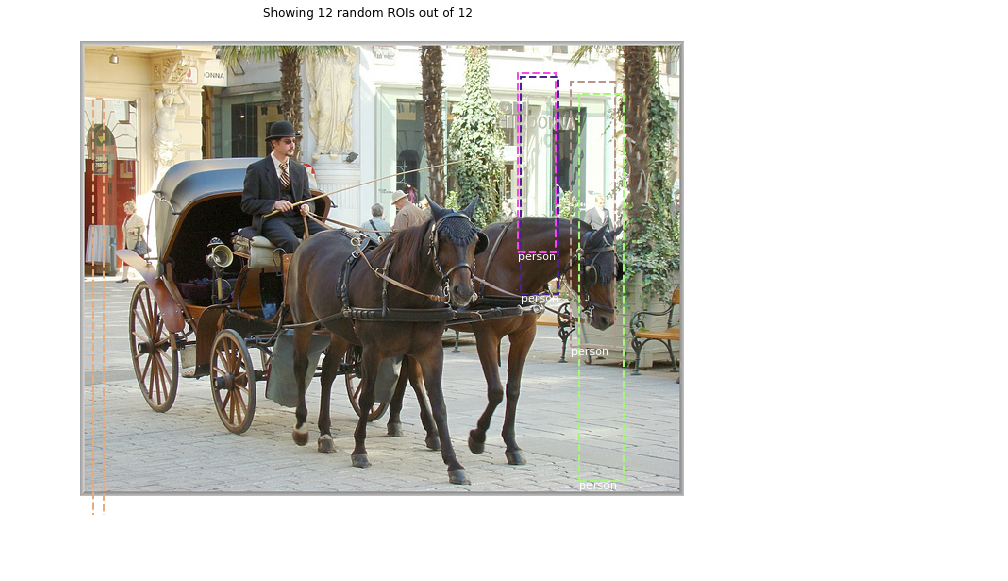

In [87]:
tf_mod_output_rois = utils.apply_box_deltas_tf(output_rois, target_bbox_deltas)
sess=tf.InteractiveSession()
with sess.as_default():
    mod_output_rois = tf_mod_output_rois.eval()
print(type(mod_output_rois))    
image_id = img_meta[img_idx,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
print('Image meta  : ', img_meta[img_idx])
print('Classes     : ', class_ids)
print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])    
# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
class_names = dataset_train.class_names
print('Class Names : ', class_names)
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

unnorm_output_rois = mod_output_rois * [1024,1024,104,1024]
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)   
visualize.draw_output_rois(image, unnorm_output_rois[0,:12], target_class_ids[0,:12], class_names, limit=10)

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

### overlaps_graph_mod

In [162]:
with sess.as_default():
    boxes1 = proposals
    boxes2 = gt_boxes
# def overlaps_graph_mod(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 2000 (training) or 1000 (inference)
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
                        The dimensionality :
                            row:  number of non_zero proposals 
                            cols: number of non_zero gt_bboxes
    '''
    ##------------------------------------------------------------------------------------------------------------
    ## 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    ##    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    ##  b1: duplicate each row of boxes1 <boxes2.shape[0]> times 
    ##      R1,R2, R3 --> R1,R1,R1,..,R2,R2,R2,...,R3,R3,R3
    ##  b2: duplicate the set of rows in boxes2 <boxes1.shape[0]> times 
    ##      R1,R2,R3 --> R1,R2,R3,R1,R2,R3,....,R1,R2,R3
    ##------------------------------------------------------------------------------------------------------------
    
    print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
    print('\t     overlaps_graph: shape of boxes1 before reshape: ',tf.shape(boxes1).eval())  # (?,?)
    print('\t     overlaps_graph: shape of boxes2 before reshape: ',tf.shape(boxes2).eval())  # (?,?)
    ### tf.expand_dims(boxes1, 1) ## makes b1:[1, batch_size, proposal_count_sz, 4] 
    
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    print('\t     overlaps_graph: shape of boxes1 after reshape: ',tf.shape(b1).eval())  # (?,4)
    print('\t     overlaps_graph: shape of boxes2 after reshape: ',tf.shape(b2).eval())  # (?,4)


    ##------------------------------------------------------------------------------------------------------------
    ## 2. Compute intersections
    ##------------------------------------------------------------------------------------------------------------
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
    print('     overlaps_graph: shape of b1_y1 after split: ',b2_y1.shape)  # (?,4)
    
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    ##------------------------------------------------------------------------------------------------------------
    ## 3. Compute unions
    ##------------------------------------------------------------------------------------------------------------
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    ##------------------------------------------------------------------------------------------------------------
    ## 4. Compute IoU and reshape to [boxes1, boxes2]
    ##------------------------------------------------------------------------------------------------------------
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    print('\t     Overlaps_graph(): Shape of output overlaps', tf.shape(overlaps), overlaps.get_shape())

	>>> detection_targets_graph - calculate Overlaps_graph
	     overlaps_graph: shape of boxes1 before reshape:  [2000    4]
	     overlaps_graph: shape of boxes2 before reshape:  [6 4]
	     overlaps_graph: shape of boxes1 after reshape:  [12000     4]
	     overlaps_graph: shape of boxes2 after reshape:  [12000     4]
     overlaps_graph: shape of b1_y1 after split:  (?, 1)
	     Overlaps_graph(): Shape of output overlaps Tensor("Shape_79:0", shape=(2,), dtype=int32) (?, ?)


In [163]:
with sess.as_default():
    r_proposals = proposals.eval()
    r_gt_boxes = gt_boxes.eval()
    r_b1 = b1.eval()
    r_b2 = b2.eval()
    r_b1_area = b1_area.eval()
    r_b2_area = b2_area.eval()
    r_intersection = intersection.eval()
    r_union = union.eval()
    r_iou   = iou.eval()
    r_overlaps = overlaps.eval()
    r_b1_y1 = b1_y1.eval()
    r_b1_y2 = b1_y2.eval()
    r_b1_x1 = b1_x1.eval()
    r_b1_x2 = b1_x2.eval()

In [164]:
r_int, r_un, r_io, r_ovr = overlaps_graph_np(r_proposals, r_gt_boxes)

print(' proposals', r_proposals.shape)
print(r_propsals[:10])
print(' gt_boexes', r_gt_boxes.shape)
print(' b1: ',r_b1.shape)
print(r_b1[:10])
print(' b2: ',r_b2.shape)
print(r_b2[:18])
print()
# print(r_b2[1067:1079])
print(' b1_area:', r_b1_area.shape)
# print(r_b1_area)
print(' b2_area:', r_b2_area.shape)
# print(r_intersection[:1000])
print(' intersection :', r_intersection.shape, r_int.shape, 'equal :', np.all(r_intersection == r_int))
print('        union :', r_union.shape, r_un.shape, 'equal :', np.all(r_union == r_un))
print('          iou :', r_iou.shape, r_io.shape, 'equal :', np.all(r_iou == r_io))
print('      overlaps:', r_overlaps.shape, r_ovr.shape, 'equal :', np.all(r_overlaps == r_ovr))
# print(r_b1_y1.shape,r_b1_x1.shape,r_b1_y2.shape)

(2000, 4)
(6, 4)
 proposals (2000, 4)
[[    0.3529     0.0050     0.7980     0.4266]
 [    0.4176     0.0665     0.7590     0.3764]
 [    0.2087     0.3628     0.4743     0.7046]
 [    0.3898     0.4291     0.8150     0.9826]
 [    0.1800     0.0492     0.4067     0.3939]
 [    0.3551     0.4749     0.6296     0.7941]
 [    0.1352     0.2704     0.5262     0.7751]
 [    0.3326     0.8494     0.5428     0.9836]
 [    0.1480     0.0000     0.4423     0.4698]
 [    0.1582     0.8671     0.3554     0.9929]]
 gt_boexes (6, 4)
 b1:  (12000, 4)
[[    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.556

In [53]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [139]:
def overlaps_graph_np(proposals, gt_boxes):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 2000 (training) or 1000 (inference)
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
                        The dimensionality :
                            row:  number of non_zero proposals 
                            cols: number of non_zero gt_bboxes
    '''
    tst1 = r_proposals
    tst2 = r_gt_boxes
    print(tst1.shape)
    print(tst2.shape)
    ##------------------------------------------------------------------------------------------------------------
    ## 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    ##    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    ##  b1: duplicate each row of boxes1 <boxes2.shape[0]> times 
    ##      R1,R2, R3 --> R1,R1,R1,..,R2,R2,R2,...,R3,R3,R3
    ##  b2: duplicate the set of rows in boxes2 <boxes1.shape[0]> times 
    ##      R1,R2,R3 --> R1,R2,R3,R1,R2,R3,....,R1,R2,R3
    ##------------------------------------------------------------------------------------------------------------
    b1 = np.repeat(proposals, gt_boxes.shape[0],axis =0)
    b2 = np.tile(gt_boxes, (proposals.shape[0],1))    # repeat number of times of r_gt_boxes
    
    ##------------------------------------------------------------------------------------------------------------
    ## 2. Compute intersections
    ## b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    ## b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    ##------------------------------------------------------------------------------------------------------------
    y1 = np.maximum(b1[:,0], b2[:,0])
    x1 = np.maximum(b1[:,1], b2[:,1])
    y2 = np.minimum(b1[:,2], b2[:,2])
    x2 = np.minimum(b1[:,3], b2[:,3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    ##------------------------------------------------------------------------------------------------------------
    ## 3. Compute unions
    ##------------------------------------------------------------------------------------------------------------
    b1_area = (b1[:,2] - b1[:,0]) * (b1[:,3] - b1[:,1])
    b2_area = (b2[:,2] - b2[:,0]) * (b2[:,3] - b2[:,1])
    union = b1_area + b2_area - intersection
    iou = intersection / union

    overlaps = np.reshape(iou, (proposals.shape[0], gt_boxes.shape[0]))
    return np.expand_dims(intersection, axis =1), np.expand_dims(union,axis = 1), np.expand_dims(iou, axis = 1), overlaps


# print( 'rintersectoin:', rintersection.shape)
# print(r_intersection.shape)
# print('intersectoin check: ', np.all(rintersection == np.squeeze(r_intersection)))
# print('riou: ', riou.shape, 'r_iou:' ,r_iou.shape)
# print('iou check         : ',np.all(riou == np.squeeze(r_iou)))
# print('roverlaps: ', roverlaps.shape, 'r_overlaps:' ,r_overlaps.shape)
# print('overlaps check         : ',np.all(roverlaps == np.squeeze(r_overlaps)))
# print(rintersection[:20])
# print(r_intersection[:20])
# print(np.all(bb1_y1 == np.squeeze(r_b1_y1)))
# print(bb1_y1.shape, bb1_x1.shape)
# print(bb1_y1[:10], np.squeeze(r_b1_y1[:10])) ##bb1_x1[:10], bb1_y2[:10], bb1_x2[:10])
# print(roverlaps[:10])
# print(r_overlaps[:10])

In [ ]:
# tf.set_random_seed(1)
# print(' Shuffled Positive indices: \n',positive_ind_shuffled.eval())
# print(' Positive indices:         \n', positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' positive overlaps shape  :  ', tf.shape(positive_overlaps).eval())
# print(  positive_overlaps.eval())
# print(' Pos roi gt class assign  :\n', roi_gt_class_ids)
# print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval)
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment)
# print(' positive overlaps        :\n', positive_overlaps)

###  `detect_target_layer` -- non function format

In [ ]:
sess = KB.get_session()
with sess.as_default():

    proposals              = tf.identity(rpn_proposal_rois)[0]
    gt_class_ids           = tf.identity(input_gt_class_ids)[0]
    gt_boxes               = tf.identity(input_gt_bboxes_norm)[0]
    
    print(rpn_proposal_rois.shape)
    print(proposals.shape)
    print(input_gt_bboxes_norm.shape)
    print(gt_boxes.shape)
    

In [ ]:
print('>>> detection_targets_graph ')
print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('     gt_class_ids.shape    :',  tf.shape(gt_class_ids).eval())
print('     gt_masks.shape        :',  tf.shape(gt_masks).eval() )

proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")

print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('   ####  gt_boxes :\n', gt_boxes.eval())
# print(non_zeros.eval())

#------------------------------------------------------------------------------------------
##  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications
#------------------------------------------------------------------------------------------
crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

#------------------------------------------------------------------------------------------
# get unique list of classes present in current image
#------------------------------------------------------------------------------------------
gt_classes_present, _ = tf.unique(gt_class_ids)

#------------------------------------------------------------------------------------------
# Compute overlaps with crowd boxes [anchors, crowds]
#------------------------------------------------------------------------------------------
crowd_overlaps  = overlaps_graph_mod(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)


# print('crowd ixs: ', crowd_ix.eval())
# print('non_crowd_ixs', non_crowd_ix.eval())
# print('non crowd bool', no_crowd_bool.eval())
 
#------------------------------------------------------------------------------------------
# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
#------------------------------------------------------------------------------------------
overlaps        = overlaps_graph_mod(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
# print('     overlaps.shape        :',  overlaps.shape, KB.int_shape(overlaps)   )
# print('     overlaps.shape :',  tf.shape(overlaps).eval())
# print(overlaps.eval())
# print(' RoI/Gt max IoU')
# print(roi_iou_max.eval())

##------------------------------------------------------------------------------------------------------
## 1. Determine indices of postive ROI propsal boxes
##    Identify RoIs that have an IoU >= 0.5 - these are positive RoIs
##    RoIs that have a max IoU < 0.5 and are not a crowd RoI are considered negative RoIs
##------------------------------------------------------------------------------------------------------
positive_roi_bool         = (roi_iou_max >= 0.5)
all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Positive IoUs    :\n', tf.gather(roi_iou_max,all_positive_indices).eval())



#------------------------------------------------------------------------------------------
## 2. Determine indices of negative ROI proposal boxes
#------------------------------------------------------------------------------------------
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices      = tf.where(negative_nonzero_bool) [:, 0]
# print('Negative indices')
# print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
# print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

##------------------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
##------------------------------------------------------------------------------------------------------
# print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
# print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
# print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
# print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

##------------------------------------------------------------------------------------------------------
##  Select positive samples from amongst positive bounding boxes
##------------------------------------------------------------------------------------------------------
## current method
positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

## New:
positive_indices      = positive_ind_shuffled[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
##
## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
## negative count, due to the fact that positive_count is cast to an int. 
## for eg. int(32 * 0.333) = int(10.56) = 10. 
## 
## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
## some of these will be used to introduce false positives/
##------------------------------------------------------------------------------------------------------
# r = 1.0 / config.ROI_POSITIVE_RATIO
# print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
# negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
# print('Negative Count : ', negative_count.eval())

# all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
# print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
## Here is the alterantive method
## Determine Negative count as different between total RoIs per image and number of positives we found
## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  

##------------------------------------------------------------------------------------------------------
all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
false_positive_count  = tf.shape(false_positive_indices)[0]

# print('Positive Count       : ', positive_count.eval())
# print('All Negative Count   : ', all_negative_count.eval())
# print('False Positive Count Goal: ', false_positive_count_goal.eval())


# print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
# print(false_positive_indices.eval())

negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
negative_count     = tf.shape(negative_indices)[0]
# print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
#       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
# print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


##------------------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
##------------------------------------------------------------------------------------------------------
positive_rois      = tf.gather(proposals, positive_indices)
false_positive_rois= tf.gather(proposals, false_positive_indices)
negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#------------------------------------------------------------------------------------------------------
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

# print('Positive indices: \n',positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())

#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

#------------------------------------------------------------------------------------------------------
## 7.   Compute bbox delta 
#  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
#------------------------------------------------------------------------------------------------------
deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
deltas /= config.BBOX_STD_DEV
# print('deltas')
# print(deltas.eval())
# print(' Positive RoIs ')
# print(positive_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the false positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#  Idea -- instead of using arg_max, use arg_min 
#------------------------------------------------------------------------------------------------------
fp_overlaps          = tf.gather(overlaps, false_positive_indices)
fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
##--------------------------------------------------------------------------------
## To Randomly assign classes to the false positive bounding boxes,
## use the gt_class_id / OR the box_assignement to pick a class from the 
## shuffled <gt_classes_present> tensor
##--------------------------------------------------------------------------------

# print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
# print(' FP overlaps            \n', fp_overlaps.eval())
# print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
# print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
# print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

#------------------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
#------------------------------------------------------------------------------------------------------
transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
boxes = positive_rois

if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    gt_h = gt_y2 - gt_y1
    gt_w = gt_x2 - gt_x1
    y1 = (y1 - gt_y1) / gt_h
    x1 = (x1 - gt_x1) / gt_w
    y2 = (y2 - gt_y1) / gt_h
    x2 = (x2 - gt_x1) / gt_w
    boxes = tf.concat([y1, x1, y2, x2], 1)

box_ids = tf.range(0, tf.shape(roi_masks)[0])
masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   boxes,
                                   box_ids,
                                   config.MASK_SHAPE)
# Remove the extra dimension from masks.
masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
masks = tf.round(masks)

#------------------------------------------------------------------------------------------------------
# Append negative ROIs and pad bbox deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
fp_rois          = tf.concat([positive_rois, false_positive_rois, negative_rois], axis=0)
fp_roi_gt_boxes     = tf.concat([roi_gt_boxes,fp_gt_boxes], axis=0)
fp_roi_gt_class_ids = tf.concat([roi_gt_class_ids, fp_gt_class_ids],axis=0)

N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)


rois             = tf.pad(rois            , [(0, P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
deltas           = tf.pad(deltas          , [(0, N + P), (0, 0)])
masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

#------------------------------------------------------------------------------------------------------
# SSetup False Positive structures
#
#------------------------------------------------------------------------------------------------------
P1                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_rois)[0], 0)
fp_rois             = tf.pad(rois            , [(0, P1), (0, 0)])


P2                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_roi_gt_boxes)[0], 0)
fp_roi_gt_boxes     = tf.pad(fp_roi_gt_boxes    , [(0, P2), (0, 0)])
fp_roi_gt_class_ids = tf.pad(fp_roi_gt_class_ids, [(0, P2)])


In [ ]:
sess1 = tf.Session()
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [false_positive_indices, fp_overlaps, fp_gt_box_assignment, fp_gt_boxes, fp_gt_class_ids, gt_class_ids,
            fp_rois, fp_roi_gt_boxes, fp_roi_gt_class_ids,
            rois   , roi_gt_boxes   , roi_gt_class_ids]
tt = sess1.run(FeedList)
print(type(tt), len(tt))

In [ ]:

print(' False Positive indices: \n', tt[0])
print(' shape of false positive overlaps is :', tt[1].shape)
print(' FP overlaps             \n', tt[1])
print(' FP gt box assignemt:\n', tt[2])
print(' FP gt boxes        :\n', tt[3])
print(' FP gt class assign :\n', tt[4])
print(' gt class ids assign :\n', tt[5])
print()
print('fp_rois ', tt[6].shape, '\n',tt[6])
print('rois ', tt[9].shape, '\n',tt[9])
print()
print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
print()
print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

In [ ]:
print(input_gt_class_ids)

####  4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)

In [ ]:
### 5.   Gather selected positive and negative ROIs
# positive_rois      = tf.gather(proposals, positive_indices)
# false_positive_rois= tf.gather(proposals, false_positive_indices)
# negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#---------------------------------------------------------------------------------
# for each positive RoI, gather IoUs between the RoI and all gt bboxes, 
# find the index correwsponding to the gt_box with the maximum overlap, 
# and assign the corresponding gt_class and gt_bbox to the RoI
#---------------------------------------------------------------------------------
# positive_overlaps     = tf.gather(overlaps, positive_indices)
# roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
# roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
# roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
# print(' shape of positive overlaps is :', positive_overlaps.get_shape())
# print(' positive overlaps \n', positive_overlaps.eval())
# print(' roi gt box assignment', roi_gt_box_assignment.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
# deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
# deltas /= config.BBOX_STD_DEV
# print(deltas.eval())
# print(positive_rois.eval())


In [ ]:
fp_overlaps     = tf.gather(overlaps, false_positive_indices)
fp_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_box_assignment)
# print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print('positive overlaps \n', fp_overlaps.eval())
print('roi gt box assignemt', fp_box_assignment.eval())

In [ ]:
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P), (0, 0)])
print(rois.eval())
print(tf.shape(rois).eval())

###  Older Versions 

####  Older version of `detection_targets_graph`

In [ ]:
# def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
sess = KB.get_session()
with sess.as_default():

    print('>>> detection_targets_graph ')
    print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
    print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
    print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
    print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

    proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
    gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
    gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

    # print(tf.shape(proposals).eval())
    # print(non_zeros.eval())
    # print('gt_boxes :', tf.shape(gt_boxes).eval())

    ###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

    crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
    crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool   = (crowd_iou_max < 0.001)

    # print('crowd ixs: ', crowd_ix.eval())
    # print('non_crowrd_ixs', non_crowd_ix.eval())
    # print('non crowd bool', no_crowd_bool.eval())

    overlaps        = overlaps_graph(proposals, gt_boxes)
    print('     overlaps.shape :',  tf.shape(overlaps).eval())
    
    roi_iou_max            = tf.reduce_max(overlaps, axis=1)
    print(' RoI/Gt max IoU')
    # print(roi_iou_max.eval())
    positive_roi_bool     = (roi_iou_max >= 0.5)
    all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
    print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    print('Positive IoUs \n', tf.gather(roi_iou_max,all_positive_indices).eval())

    ## current method
    all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
#     print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
#     print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

    ## method - suppress the proposals with 0 IoUs
    # negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
    # negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
    # negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
    # print('Negative indices')
    # print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
    # print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

    ##------------------------------------------------------------------------------------------------------
    ## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
    ##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
    ##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
    ##------------------------------------------------------------------------------------------------------
    # print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    # print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
    # print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
    # print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

    positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
    negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
    print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
#     print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

    ##------------------------------------------------------------------------------------------------------
    ##  Select positive samples from amongst positive bounding boxes
    ##------------------------------------------------------------------------------------------------------
    ## current method
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    ## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

    ## New:
    positive_indices      = positive_ind_shuffled[:positive_count]
    positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

    ##------------------------------------------------------------------------------------------------------
    ##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    ##
    ## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
    ## negative count, due to the fact that positive_count is cast to an int. 
    ## for eg. int(32 * 0.333) = int(10.56) = 10. 
    ## 
    ## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
    ## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
    ## some of these will be used to introduce false positives/
    ##------------------------------------------------------------------------------------------------------
    # r = 1.0 / config.ROI_POSITIVE_RATIO
    # print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
    # negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
    # print('Negative Count : ', negative_count.eval())

    # all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
    # print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())
    
    ##------------------------------------------------------------------------------------------------------
    ## Here is the alterantive method
    ## Determine Negative count as different between total RoIs per image and number of positives we found
    ## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
    ##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  
    
    ##------------------------------------------------------------------------------------------------------
    all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
    false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

    false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
    false_positive_count  = tf.shape(false_positive_indices)[0]
    
    # print('Positive Count       : ', positive_count.eval())
    # print('All Negative Count   : ', all_negative_count.eval())
    # print('False Positive Count Goal: ', false_positive_count_goal.eval())


    # print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
    # print(false_positive_indices.eval())
    
    negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
    negative_count     = tf.shape(negative_indices)[0]
    # print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
    #       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
    # print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


    ##------------------------------------------------------------------------------------------------------
    ## 5.   Gather selected positive and negative ROIs
    ##------------------------------------------------------------------------------------------------------
    positive_rois      = tf.gather(proposals, positive_indices)
    false_positive_rois= tf.gather(proposals, false_positive_indices)
    negative_rois      = tf.gather(proposals, negative_indices)

    # print(positive_rois.eval())
    # print(false_positive_rois.eval())
    # print(negative_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    # 
    #  Remember: The same class can have multiple gt_bounding boxes. So RoIs assiged to same class could have 
    #            DIFFERENT gt_bboxes (classes can have multple bounding boxes -- like when the same shape 
    #           appears twice in an image)
    #------------------------------------------------------------------------------------------------------
    positive_overlaps     = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
    roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
    
#     print('Positive indices: \n',positive_indices.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' positive overlaps shape  :  ', sess.run(positive_overlaps, roi_gt_box_assignment))
#     print(tf.reduce_max(positive_overlaps, axis = 1).eval())
#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

    #------------------------------------------------------------------------------------------------------
    ## 7.   Compute bbox delta 
    #  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
    #------------------------------------------------------------------------------------------------------
    deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV
    # print('deltas')
    # print(deltas.eval())
    # print(' Positive RoIs ')
    # print(positive_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the false positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    #
    #------------------------------------------------------------------------------------------------------
    fp_overlaps          = tf.gather(overlaps, false_positive_indices)
    fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
    fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
    fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
#     print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
    # print(' FP overlaps            \n', fp_overlaps.eval())
    # print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
    # print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
    # print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
    return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

#### Another old version of `detection_targets_graph`

In [41]:
# def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
THIS IS THE OLD VERSION  
'''
as of 16-0-2018
Generates detection targets for one image. Subsamples proposals and
generates target class IDs, bounding box deltas, and masks for each.

Inputs:
-------
proposals:          [N, 2000, (y1, x1, y2, x2)] in normalized coordinates. 
                         Might be zero padded if there are not enough proposals.
gt_class_ids:       [MAX_GT_INSTANCES] int class IDsMx2)] in normalized coordinates.
gt_masks:           [height, width, MAX_GT_INSTANCES] of boolean type.

Returns:            Target ROIs and corresponding class IDs, bounding box shifts, and masks.
--------
rois:               [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
class_ids:          [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
deltas:             [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
                    Class-specific bbox refinments.
masks:              [TRAIN_ROIS_PER_IMAGE, height, width). Masks cropped to bbox
                    boundaries and resized to neural network output size.

Note: Returned arrays might be zero padded if not enough target ROIs.

''' 
# Assertions
asserts = [
    tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals], name="roi_assertion"),
]

with tf.control_dependencies(asserts):
    proposals = tf.identity(proposals)
# print('>>> detection_targets_graph ')
# print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
# print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
# print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
# print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

# Remove zero padding   
# non_zeros returns indicies to valid bboxes, which we use to index gt_class_ids, and gt_masks
proposals, non_zeros1= utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
# gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

print(tf.reduce_all(non_zeros1).eval())
print(tf.shape(proposals).eval())
print(non_zeros.eval())
print(tf.shape(gt_boxes).eval())
print(gt_boxes.eval())

#------------------------------------------------------------------------------------------
# Handle COCO crowds
# A crowd box in COCO is a bounding box around several instances. Exclude
# them from training. A crowd box is given a negative class ID.
#------------------------------------------------------------------------------------------
# tf.where : returns the coordinates of true elements of  the specified conditon.
#            The coordinates are returned in a 2-D tensor where the first dimension (rows) 
#            represents the number of true elements, and the second dimension (columns) 
#            represents the coordinates of the true elements. 
#            Keep in mind, the shape of the output tensor can vary depending on how many 
#            true values there are in input. Indices are output in row-major order.
#
# tf.gather: Gather slices from params axis (default = 0) according to indices.
#            indices must be an integer tensor of any dimension (usually 0-D or 1-D). 
#            Produces an output tensor with shape:
#                   params.shape[:axis] + indices.shape + params.shape[axis + 1:] 
#
# tf.squeeze: Removes dimensions of size 1 from the shape of a tensor.
#            Given a tensor input, this operation returns a tensor of the same type with 
#            all dimensions of size 1 removed. If you don't want to remove all size 1 
#            dimensions, you can remove specific size 1 dimensions by specifying axis.
#------------------------------------------------------------------------------------------

crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
print(non_crowd_ix.eval())
print(gt_boxes.eval())

# Compute overlaps with crowd boxes [anchors, crowds]
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
overlaps        = overlaps_graph(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
print('     overlaps.shape        :',  tf.shape(overlaps).eval())
print(overlaps.eval())
zero_idxs = tf.where(tf.greater_equal(overlaps,0.5))
print(tf.shape(zero_idxs).eval())

## 1. Determine indices of postive ROI propsal boxes
#    Identify ROI proposal boxes that have an IoU >= 05 overlap with some gt_box, and store 
#    indices into positive_indices
positive_roi_bool     = (roi_iou_max >= 0.5)
positive_indices      = tf.where(positive_roi_bool)[:,0]
print(tf.shape(positive_roi_bool).eval())
print(tf.shape(positive_indices).eval())
print(positive_indices.eval())



## 2. Determine indices of negative ROI proposal boxes
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices2     = tf.where(negative_nonzero_bool) [:, 0]

## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
#    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
#    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE ~  11
positive_count        = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
positive_indices      = tf.random_shuffle(positive_indices)[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

print(positive_indices.eval())
print(positive_count.eval())

## 4. Add Negative ROIs. Add enough to maintain positive:negative ratio
#     negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)
r = 1.0 / config.ROI_POSITIVE_RATIO
negative_count        = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
negative_indices      = tf.random_shuffle(negative_indices)[:negative_count]

## 5.   Gather selected positive and negative ROIs
positive_rois         = tf.gather(proposals, positive_indices)
negative_rois         = tf.gather(proposals, negative_indices)
print(positive_rois.eval())

## 6.   Assign positive ROIs to GT boxes.
#      roi_gt_box_assignment shows for each positive overlap, which class has the maximum overlap
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print(roi_gt_box_assignment.eval())
print(positive_overlaps.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and gt_boxes) for positive ROIs
roi_gt_deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
roi_gt_deltas /= config.BBOX_STD_DEV

## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
# transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
# roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
# boxes = positive_rois

# if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    # y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    # gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    # gt_h = gt_y2 - gt_y1
    # gt_w = gt_x2 - gt_x1
    # y1 = (y1 - gt_y1) / gt_h
    # x1 = (x1 - gt_x1) / gt_w
    # y2 = (y2 - gt_y1) / gt_h
    # x2 = (x2 - gt_x1) / gt_w
    # boxes = tf.concat([y1, x1, y2, x2], 1)

# box_ids = tf.range(0, tf.shape(roi_masks)[0])
# masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   # boxes,
                                   # box_ids,
                                   # config.MASK_SHAPE)

# Remove the extra dimension from masks.
# masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
# masks = tf.round(masks)

# Append negative ROIs and pad bbox roi_gt_deltas and masks that
# are not used for negative ROIs with zeros.
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P ), (0, 0)])

roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
roi_gt_deltas    = tf.pad(roi_gt_deltas   , [(0, N + P), (0, 0)])
# masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

# print(' roi_gt_boxes :  ' , tf.shape(roi_gt_boxes) )
# print(' P:  ' , P,  ' N :    ', N)   
# print('     roi.shape             :',  rois.shape            , tf.shape(rois))
# print('     roi_gt_class_ids.shape:',  roi_gt_class_ids.shape, tf.shape(roi_gt_class_ids))
# print('     roi_gt_deltas.shape   :',  roi_gt_deltas.shape   , tf.shape(roi_gt_deltas))
# print('     masks.shape           :',  masks.shape           , tf.shape(masks))
# print('     roi_gt_boxes.shape    :',  roi_gt_boxes.shape    , tf.shape(roi_gt_boxes))

#     return rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes
#     return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment, roi_gt_boxes, roi_gt_class_ids

True
[2000    4]
[ True  True  True]
[3 4]
[[0.     0.     0.4453 0.5703]
 [0.0547 0.3984 0.3906 0.7344]
 [0.5859 0.1641 0.9375 0.5156]]
[0 1 2]
[[0.     0.     0.4453 0.5703]
 [0.0547 0.3984 0.3906 0.7344]
 [0.5859 0.1641 0.9375 0.5156]]
     overlaps.shape        : [2000    3]
[[0.0836 0.     0.    ]
 [0.0017 0.     0.    ]
 [0.0105 0.     0.    ]
 ...
 [0.0006 0.0013 0.    ]
 [0.0285 0.     0.044 ]
 [0.     0.     0.    ]]
[8 2]
[2000]
[8]
[ 257  365  420  432  661  798  991 1264]
[1264  432  661  991  420  798  257  365]
8
[[0.5462 0.26   1.     0.5613]
 [0.     0.     0.3301 0.7111]
 [0.     0.     0.4078 0.4211]
 [0.     0.     0.675  0.5631]
 [0.6335 0.0174 0.8874 0.4826]
 [0.5844 0.     1.     0.5543]
 [0.     0.009  0.6593 0.411 ]
 [0.     0.14   0.3856 0.6639]]
     shape of positive overlaps is : (?, ?)
[0 0 2 0 2 0 2 0]
[[0.     0.     0.5028]
 [0.6266 0.3293 0.    ]
 [0.     0.     0.5365]
 [0.5266 0.0113 0.0489]
 [0.6542 0.1264 0.0663]
 [0.     0.     0.5272]
 [0.6762 0.0

####  Older version of `overlaps_graph_mod`

In [ ]:
def overlaps_graph_mod(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 1000 or 2000 based on training or inference
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
    '''
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    #    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    
#     print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
#     print('\t     overlaps_graph: shape of boxes1 before reshape: ',tf.shape(boxes1).eval())  # (?,?)
#     print('\t     overlaps_graph: shape of boxes2 before reshape: ',tf.shape(boxes2).eval())  # (?,?)
    
    # tf.expand_dims(boxes1, 1) : makes b1:[1, proposal_count_sz, 4] 
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    
#     print('\t     overlaps_graph: shape of boxes1 after reshape: ',tf.shape(b1).eval())  # (?,4)
#     print('\t     overlaps_graph: shape of boxes2 after reshape: ',tf.shape(b2).eval())  # (?,4)

    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
#     print('     overlaps_graph: shape of b1_y1 after split: ',tf.shape(b2_y1).eval())  # (?,4)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
#     print('\t     Overlaps_graph(): Shape of output overlaps', tf.shape(overlaps).eval(), overlaps.get_shape())
    return overlaps





